# Predcition of Hospital Admission Related to Urinary Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to urinary tract infection (uti).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'uti_date_'+str(i), 'uti_ab_date_'+str(i), 'uti_ab_type_'+str(i),
                   'incdt_uti_date_'+str(i), 'admitted_uti_date_'+str(i), 'sgss_gp_cov_uti_date_'+str(i)]]
    
    #drop rows with no uti reord
    datum = datum[datum['uti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with uti_i
    datum = datum[datum['sgss_gp_cov_uti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'uti_date_'+str(i): 'uti_date', 'uti_ab_date_'+str(i): 'uti_ab_date', 
                           'uti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_uti_date_'+str(i): 'incdt_uti_date', 'incdt_uti_type_'+str(i): 'incdt_uti_type',
                           'admitted_uti_date_'+str(i): 'admitted_uti_date',
                           'sgss_gp_cov_uti_date_'+str(i): 'sgss_gp_cov_uti_date'},
                inplace=True)
    
    return datum

In [5]:
#preparation of data for cox models
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    data_req = data[vars+vars_countinuous+vars_output]
    #encoding categorical data for cox models
    data_enc = data_req[vars+vars_countinuous].reset_index()
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [6]:
#summary table of observation counts
def make_summary_table(infection, infection_type, data):
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
#summary table of hospitalised cases
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    #encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()

    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [8]:
#build cox models
def cox_model_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [9]:
#save coefficients (betas) and calculate sum of betas
def cox_betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    #save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    #transpose and sort covariates and coefficients
    covariatesT = covariates.T
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data

    #further cleaning up covariates to make them compatible with the encoded data
    covariates_list = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    covariates_list = [value.replace("'", "") for value in covariates_list] #removes double quotation mark 

    #match covariates_list (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(covariates_list)] 
    data = data.sort_index(axis = 1) #sort 

    #multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')

    #sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    
    #predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  

    #sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    #separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))

    #select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    #save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [10]:
def cox_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    #analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [11]:
#calculate and plot calibrations of cox models
def cox_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']

    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T 
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [12]:
#print outputs of cox models
def cox_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    #calculate concordance index
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    #save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [13]:
#build cox model with an additional binary variable for antibiotics
def cox_model_abs_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + uti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [14]:
#build cox model with an additional categorical variable for antibiotics
def cox_model_ab_type_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [15]:
#build cox models stratified with sex categories 
def cox_model_strat_sex_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + uti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [16]:
#build cox models stratified with age categories
def cox_model_strat_age_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + uti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [17]:
#build cox models stratified with time period categories 
def cox_model_strat_period_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + uti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [18]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_uti.csv.gz')

In [19]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [20]:
#process 20 utis and concatenate them 
data_uti_1 = proc_infec_data(data,1)
data_uti_2 = proc_infec_data(data,2)
data_uti_3 = proc_infec_data(data,3)
data_uti_4 = proc_infec_data(data,4)
data_uti_5 = proc_infec_data(data,5)
data_uti_6 = proc_infec_data(data,6)
data_uti_7 = proc_infec_data(data,7)
data_uti_8 = proc_infec_data(data,8)
data_uti_9 = proc_infec_data(data,9)
data_uti_10 = proc_infec_data(data,10)
data_uti_11 = proc_infec_data(data,11)
data_uti_12 = proc_infec_data(data,12)
data_uti_13 = proc_infec_data(data,13)
data_uti_14 = proc_infec_data(data,14)
data_uti_15 = proc_infec_data(data,15)
data_uti_16 = proc_infec_data(data,16)
data_uti_17 = proc_infec_data(data,17)
data_uti_18 = proc_infec_data(data,18)
data_uti_19 = proc_infec_data(data,19)
data_uti_20 = proc_infec_data(data,20)

data_uti = pd.concat([data_uti_1, data_uti_2, data_uti_3, data_uti_4, data_uti_5, data_uti_6, data_uti_7, data_uti_8, data_uti_9, data_uti_10, data_uti_11, data_uti_12, data_uti_13, data_uti_14, data_uti_15, data_uti_16, data_uti_17, data_uti_18, data_uti_19, data_uti_20])
data_uti.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [21]:
##add variable season
#convert data types
data_uti['uti_date'] = data_uti['uti_date'].astype('datetime64[ns]')
data_uti['admitted_uti_date'] = data_uti['admitted_uti_date'].astype('datetime64[ns]')
data_uti.died_date = data_uti.died_date.astype('datetime64[ns]')
data_uti.deregistered_date = data_uti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_uti['date'] = data_uti['uti_date'] 
data_uti['date'] = data_uti['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_uti with today's date in year and month
data_uti = data_uti[data_uti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_uti = data_uti[data_uti['date'] != last_1_month_date_y_m]
data_uti = data_uti[data_uti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of uti records
data_uti['season'] = np.nan
data_uti['date_month'] = pd.DatetimeIndex(data_uti['date']).month

conditions = [
    (data_uti['date_month'] >= 3) & (data_uti['date_month'] <= 5),
    (data_uti['date_month'] >= 6) & (data_uti['date_month'] <= 8),
    (data_uti['date_month'] >= 9) & (data_uti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_uti['season'] = np.select(conditions, choices, default='winter')

In [22]:
#add variable time period
data_uti.loc[(data_uti['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_uti.loc[((data_uti['date'] >= '2020-01') & (data_uti['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_uti.loc[(data_uti['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [23]:
#scenario 1
#not hosped (nothing happened)
data_uti.loc[data_uti['admitted_uti_date'].isnull(), 'event_uti_admitted'] = 0

In [24]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_uti['delta_uti_admitted'] = (data_uti['admitted_uti_date'] - data_uti['uti_date']).dt.days
data_uti.loc[((data_uti['delta_uti_admitted'] >= 0) & (data_uti['delta_uti_admitted'] <= 30)), 'event_uti_admitted'] = 1

#scenario 2
#drop whoever was admitted before uti consultation, i.e. negative value for delta_uti_admitted
data_uti = data_uti[~(data_uti['delta_uti_admitted'] < 0)]

In [25]:
#scenario 3
#censor died patients
data_uti['delta_admitted_died'] = (data_uti['died_date'] - data_uti['admitted_uti_date']).dt.days
data_uti.loc[data_uti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_uti.loc[((data_uti['delta_admitted_died'] >= 0) & (data_uti['delta_admitted_died'] <= 30)), 'event_uti_admitted'] = 0

#scenario 3
#censor deregistered patients
data_uti['delta_admitted_deregistered'] = (data_uti['deregistered_date'] - data_uti['admitted_uti_date']).dt.days
data_uti.loc[data_uti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_uti.loc[((data_uti['delta_admitted_deregistered'] > 0) & (data_uti['delta_admitted_deregistered'] <= 30)), 'event_uti_admitted'] = 0

#agg scenario 3s
data_uti['delta_admitted_died_deregistered'] = data_uti['delta_admitted_deregistered'].combine_first(data_uti['delta_admitted_died'])
data_uti.loc[data_uti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [26]:
#scenario 1
#any other patients (nothing happened)
data_uti['event_uti_admitted'] = data_uti['event_uti_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_uti['duration_uti_admitted'] = data_uti['delta_uti_admitted'].combine_first(data_uti['delta_admitted_died_deregistered'])
data_uti['duration_uti_admitted'] = data_uti['duration_uti_admitted'].replace(np.NaN, 30)
data_uti.loc[(data_uti['duration_uti_admitted'] > 30), 'duration_uti_admitted'] = 30

#give value 1 to event_uti_admitted if duration_uti_admitted is greater or equal to 0 and less than 30
data_uti.loc[((data_uti['duration_uti_admitted'] >= 0) & (data_uti['duration_uti_admitted'] < 30)), 'event_uti_admitted'] = 1

#drop any rows with value 0 in duration column
data_uti = data_uti[~(data_uti['duration_uti_admitted'] == 0)]

In [27]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_uti.loc[((data_uti['delta_uti_admitted'] > 0) & (data_uti['delta_uti_admitted'] < 30)), 'event_uti_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [28]:
#drop anybody with age less than 18 or 0!
data_uti = data_uti[~(data_uti['age'] < 18)] 
data_uti['age'][data_uti['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_uti = data_uti[data_uti['age_cat'] != '0-4']
data_uti = data_uti[data_uti['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_uti['bmi'][data_uti['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_uti['bmi'] = data_uti['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_uti['antibacterial_brit'][data_uti['antibacterial_brit'] < 0] = np.nan

In [29]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_uti = data_uti.replace({"sex": dict_sex})
data_uti = data_uti.replace({"smoking_status": dict_smoking})

In [30]:
#drop rows with missing region
if ('region' in data_uti.columns) and (data_uti['region'].isnull().sum() > 0):
   data_uti = data_uti[data_uti['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_uti.columns) and (data_uti['antibacterial_brit'].isnull().sum() > 0):
    data_uti['antibacterial_brit'] = data_uti['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_uti.columns) and (data_uti['ethnicity'].isnull().sum() > 0):
    data_uti['ethnicity'] = data_uti['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking_status' in data_uti.columns) and (data_uti['smoking_status'].isnull().sum() > 0):
    data_uti['smoking_status'] = data_uti['smoking_status'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_uti.columns) and (data_uti['imd'].isnull().sum() > 0):
    data_uti['imd'] = data_uti['imd'].fillna(0)

In [31]:
#missing values of bmi assign 5 and 0; categorise bmi
data_uti['bmi_cat'] = 5

for idx, x in enumerate(data_uti['bmi_cat']):
    if data_uti.iat[idx, data_uti.columns.get_loc('bmi')] >= 30:
        data_uti.iat[idx, data_uti.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_uti.iat[idx, data_uti.columns.get_loc('bmi')] >= 25) and (data_uti.iat[idx, data_uti.columns.get_loc('bmi')] < 30):
        data_uti.iat[idx, data_uti.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_uti.iat[idx, data_uti.columns.get_loc('bmi')] >= 18.5) and (data_uti.iat[idx, data_uti.columns.get_loc('bmi')] < 25):
        data_uti.iat[idx, data_uti.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_uti.iat[idx, data_uti.columns.get_loc('bmi')] < 18.5:
        data_uti.iat[idx, data_uti.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_uti.columns) and (data_uti['bmi_cat'].isnull().sum() > 0):
    data_uti['bmi_cat'] = data_uti['bmi_cat'].fillna(0)

In [32]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_uti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_uti['ab_type_cat'] = np.where(data_uti['ab_type'].isin(ab_series[mask].index),'other',data_uti['ab_type'])
#assign no to non ab users
data_uti.loc[data_uti['uti_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_uti['ab_type_cat'] = data_uti['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [33]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_uti = data_uti.replace({"sex": dict_sex})
data_uti = data_uti.replace({"ethnicity": dict_ethnicity})
data_uti = data_uti.replace({"smoking_status": dict_smoking})
data_uti = data_uti.replace({"imd": dict_imd})
data_uti = data_uti.replace({"bmi_cat": dict_bmi})
data_uti = data_uti.replace({"flu_vaccine": dict_flu})
data_uti = data_uti.replace({"region": dict_region})
data_uti = data_uti.replace({"age_cat": dict_age})
data_uti = data_uti.replace({"ab_type_cat": dict_ab_type})

### 2-5- categorising and assigning max value for continuous variables

In [34]:
#categorise CCI
data_uti['CCI_cat'] = pd.cut(data_uti['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_uti['antibacterial_brit'].clip(0, data_uti['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

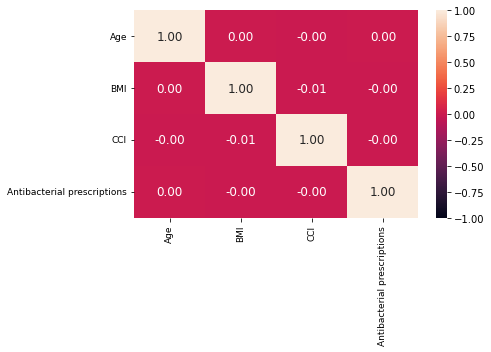

In [35]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_uti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_uti/corr_uti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [36]:
data_uti = data_uti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                                   'antibacterial_brit', 'uti_ab_date', 'ab_type_cat', 'incdt_uti_date', 'date', 'period',
                                   'event_uti_admitted', 'duration_uti_admitted'
                                    ]]

In [37]:
#incident and prevalent infection 
data_uti_incdt = data_uti[data_uti['incdt_uti_date'] == 0]
data_uti_prevl = data_uti[data_uti['incdt_uti_date'] == 1]
#switch variable uti_ab_date into a binary variable
data_uti_incdt[['uti_ab_date']] = data_uti_incdt[['uti_ab_date']].where(data_uti_incdt[['uti_ab_date']].isnull(), 1).fillna(0).astype(int)
data_uti_prevl[['uti_ab_date']] = data_uti_prevl[['uti_ab_date']].where(data_uti_prevl[['uti_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_uti_incdt_males = data_uti_incdt[data_uti_incdt['sex'] == 'male']
data_uti_incdt_females = data_uti_incdt[data_uti_incdt['sex'] == 'female']
data_uti_prevl_males = data_uti_prevl[data_uti_prevl['sex'] == 'male']
data_uti_prevl_females = data_uti_prevl[data_uti_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_uti_incdt_15_24 = data_uti_incdt[data_uti_incdt['age_cat'] == '15_24']
data_uti_incdt_25_34 = data_uti_incdt[data_uti_incdt['age_cat'] == '25_34']
data_uti_incdt_35_44 = data_uti_incdt[data_uti_incdt['age_cat'] == '35_44']
data_uti_incdt_45_54 = data_uti_incdt[data_uti_incdt['age_cat'] == '45_54']
data_uti_incdt_55_64 = data_uti_incdt[data_uti_incdt['age_cat'] == '55_64']
data_uti_incdt_65_74 = data_uti_incdt[data_uti_incdt['age_cat'] == '65_74']
data_uti_incdt_75_more = data_uti_incdt[data_uti_incdt['age_cat'] == '75_more']
data_uti_prevl_15_24 = data_uti_prevl[data_uti_prevl['age_cat'] == '15_24']
data_uti_prevl_25_34 = data_uti_prevl[data_uti_prevl['age_cat'] == '25_34']
data_uti_prevl_35_44 = data_uti_prevl[data_uti_prevl['age_cat'] == '35_44']
data_uti_prevl_45_54 = data_uti_prevl[data_uti_prevl['age_cat'] == '45_54']
data_uti_prevl_55_64 = data_uti_prevl[data_uti_prevl['age_cat'] == '55_64']
data_uti_prevl_65_74 = data_uti_prevl[data_uti_prevl['age_cat'] == '65_74']
data_uti_prevl_75_more = data_uti_prevl[data_uti_prevl['age_cat'] == '75_more']

#incident and prevalent infection stratified by time period categories
data_uti_incdt_prepandemic = data_uti_incdt[data_uti_incdt['date'] <= '2019-12']
data_uti_incdt_during_pandemic = data_uti_incdt[(data_uti_incdt['date'] >= '2020-03') & (data_uti_incdt['date']<= '2021-03')]
data_uti_incdt_post_2nd_lockdown = data_uti_incdt[data_uti_incdt['date'] <= '2021-04']
data_uti_prevl_prepandemic = data_uti_prevl[data_uti_prevl['date'] <= '2019-12']
data_uti_prevl_during_pandemic = data_uti_prevl[(data_uti_prevl['date'] >= '2020-03') & (data_uti_prevl['date']<= '2021-03')]
data_uti_prevl_post_2nd_lockdown = data_uti_prevl[data_uti_prevl['date'] <= '2021-04']

# no antibiotics and incident hospital admission
data_uti_no_abs_incdt = data_uti[data_uti['uti_ab_date'].isnull()]
data_uti_no_abs_incdt = data_uti_no_abs_incdt[data_uti_no_abs_incdt['incdt_uti_date'] == 0]

# with antibiotics and incident hospital admission
data_uti_abs_incdt = data_uti[data_uti['uti_ab_date'].notnull()]
data_uti_abs_incdt = data_uti_abs_incdt[data_uti_abs_incdt['incdt_uti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_uti_no_abs_prevl = data_uti[data_uti['uti_ab_date'].isnull()]
data_uti_no_abs_prevl = data_uti_no_abs_prevl[data_uti_no_abs_prevl['incdt_uti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_uti_abs_prevl = data_uti[data_uti['uti_ab_date'].notnull()]
data_uti_abs_prevl = data_uti_abs_prevl[data_uti_abs_prevl['incdt_uti_date'] == 1]

In [38]:
#store data for plotting hosp admission counts and percentages
%store data_uti
# save data
data_uti.to_csv('../output/hospitalisation_prediction_uti/data_uti.csv')

Stored 'data_uti' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident uti with no antibiotics

<lifelines.CoxPHFitter: fitted with 112644 total observations, 111803 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 112644
number of events observed = 841
   partial log-likelihood = -9752.60
         time fit was run = 2023-02-02 11:23:50 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.19       1.20       0.11            -0.03             0.40                 0.97                 1.49
CCI_cat[T.medium]                0.20       1.22       0.12            -0.03             0.43                 0.97                 1.53
CCI_cat[T.high]                  0.29       1.33       0.14             0.02             0.55                 1.02                 1.74
CCI_cat[T.very_high]             0.10       1.11       0.13            -0.15             0.35                 0.86                 1.42
age_cat[T.25_34]                -0.07       0.94       0.13            -0.33             0.20                 0.72                 1.22
age_cat[T.35_44]                 0.09       1.10       0.13            -0.16             0.35                 0.85                 1.41
age_cat[T.45_54]                -0.08       0.93       0.14            -0.34             0.19                 0.71                 1.21
age_cat[T.55_64]                 0.20       1.22       0.13            -0.05             0.45                 0.95                 1.56
age_cat[T.65_74]                 0.11       1.11       0.13            -0.15             0.36                 0.86                 1.43
age_cat[T.75_more]               0.10       1.10       0.13            -0.15             0.35                 0.86                 1.42
antibacterial_brit              -0.01       0.99       0.02            -0.06             0.04                 0.95                 1.04
bmi_cat[T.obese]                 0.09       1.10       0.14            -0.17             0.36                 0.84                 1.43
bmi_cat[T.overweight]            0.28       1.32       0.16            -0.03             0.59                 0.97                 1.80
bmi_cat[T.underweight]           0.04       1.04       0.23            -0.42             0.49                 0.66                 1.64
bmi_cat[T.unknown]               0.06       1.07       0.14            -0.22             0.35                 0.80                 1.42
ethnicity[T.unknown]             0.28       1.33       0.12             0.04             0.52                 1.05                 1.68
ethnicity[T.white]               0.29       1.33       0.11             0.07             0.50                 1.07                 1.65
flu_vaccine[T.yes]              -0.30       0.74       0.13            -0.55            -0.04                 0.58                 0.96
imd[T.medium]                   -0.14       0.87       0.12            -0.37             0.08                 0.69                 1.09
imd[T.unaffluent]               -0.15       0.86       0.12            -0.37             0.08                 0.69                 1.08
imd[T.unknown]                   0.19       1.21       0.16            -0.12             0.50                 0.89                 1.65
imd[T.very_affluent]             0.02       1.02       0.11            -0.19             0.24                 0.83                 1.27
imd[T.very_unaffluent]           0.04       1.04       0.11            -0.18             0.25                 0.84                 1.29
region[T.east_midlands]         -0.09       0.91       0.15            -0.39             0.21                 0.68                 1.23
region[T.london]                -0.00       1.00       0.13        

11954


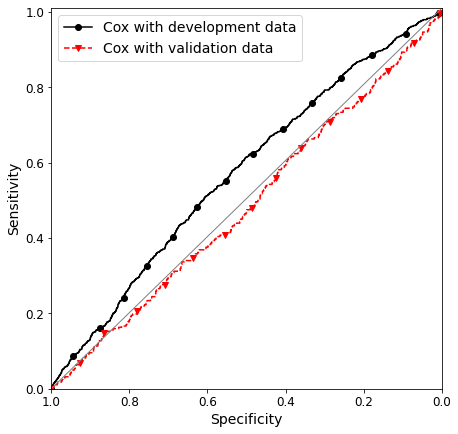

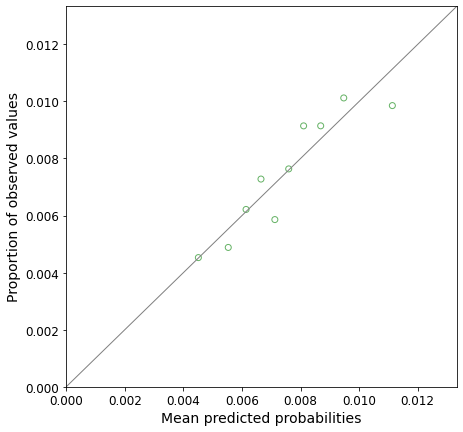

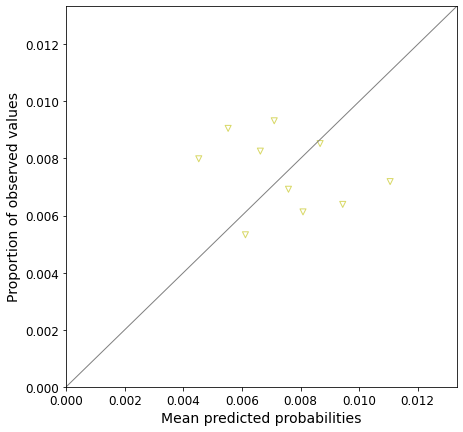

In [39]:
#data prep
data, data_uti_no_abs_incdt_enc = cox_data_prep(data_uti_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary table
make_summary_table('uti', 'no_abs_incdt', data_uti_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('uti', 'no_abs_incdt', data_uti_no_abs_incdt)

try:
    #build cox model 
    cph_uti_no_abs_incdt, data_uti_no_abs_incdt_train, data_uti_no_abs_incdt_test = cox_model_build('uti', 'no_abs_incdt', data_uti_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_uti_no_abs_incdt, '../output/hospitalisation_prediction_uti/', 'betas_cph_uti_no_abs_incdt.csv', data_uti_no_abs_incdt_enc, data_uti_no_abs_incdt, 'sum_betas_cph_uti_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_uti_no_abs_incdt, 'event_uti_admitted', data_uti_no_abs_incdt_train, data_uti_no_abs_incdt_test, '../output/hospitalisation_prediction_uti', 'roc_cph_uti_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_uti_no_abs_incdt, data_uti_no_abs_incdt_train, 'event_uti_admitted', data_uti_no_abs_incdt_test, '../output/hospitalisation_prediction_uti/', 'calibration_cph_uti_no_abs_incdt_train.jpg', 'calibration_cph_uti_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_uti_no_abs_incdt, 'uti', 'no_abs_incdt', data_uti_no_abs_incdt_train, data_uti_no_abs_incdt_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident uti with antibiotics

<lifelines.CoxPHFitter: fitted with 12564 total observations, 12475 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 12564
number of events observed = 89
   partial log-likelihood = -822.81
         time fit was run = 2023-02-02 11:24:12 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.04       1.04       0.35            -0.64             0.72                 0.53                 2.06
CCI_cat[T.medium]                0.34       1.41       0.36            -0.37             1.05                 0.69                 2.87
CCI_cat[T.high]                  0.35       1.42       0.42            -0.47             1.17                 0.62                 3.22
CCI_cat[T.very_high]             0.33       1.40       0.37            -0.40             1.07                 0.67                 2.90
age_cat[T.25_34]                -0.03       0.97       0.41            -0.83             0.77                 0.44                 2.16
age_cat[T.35_44]                 0.20       1.22       0.39            -0.57             0.96                 0.57                 2.60
age_cat[T.45_54]                 0.20       1.23       0.39            -0.56             0.97                 0.57                 2.63
age_cat[T.55_64]                -0.30       0.74       0.44            -1.16             0.57                 0.31                 1.77
age_cat[T.65_74]                -0.10       0.90       0.42            -0.92             0.72                 0.40                 2.05
age_cat[T.75_more]               0.23       1.25       0.39            -0.53             0.99                 0.59                 2.68
antibacterial_brit              -0.08       0.92       0.08            -0.23             0.07                 0.79                 1.07
bmi_cat[T.obese]                 0.67       1.95       0.52            -0.35             1.69                 0.70                 5.40
bmi_cat[T.overweight]            0.09       1.09       0.65            -1.18             1.35                 0.31                 3.87
bmi_cat[T.underweight]           0.68       1.98       0.76            -0.82             2.18                 0.44                 8.85
bmi_cat[T.unknown]               0.74       2.09       0.54            -0.31             1.79                 0.73                 5.99
ethnicity[T.unknown]             0.86       2.37       0.46            -0.03             1.76                 0.97                 5.84
ethnicity[T.white]               0.90       2.47       0.43             0.06             1.74                 1.07                 5.72
flu_vaccine[T.yes]               0.20       1.22       0.34            -0.46             0.86                 0.63                 2.36
imd[T.medium]                   -0.27       0.76       0.34            -0.94             0.40                 0.39                 1.49
imd[T.unaffluent]               -0.25       0.78       0.34            -0.91             0.41                 0.40                 1.51
imd[T.unknown]                   0.17       1.18       0.47            -0.75             1.08                 0.47                 2.95
imd[T.very_affluent]            -0.52       0.59       0.37            -1.24             0.19                 0.29                 1.21
imd[T.very_unaffluent]          -0.01       0.99       0.32            -0.64             0.61                 0.53                 1.83
region[T.east_midlands]         -0.63       0.53       0.51            -1.63             0.36                 0.20                 1.44
region[T.london]                -0.24       0.78       0.39            -

11966


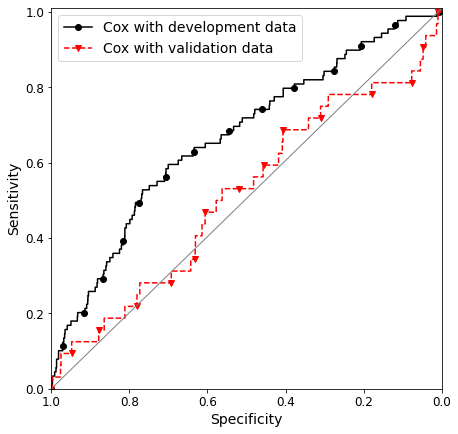

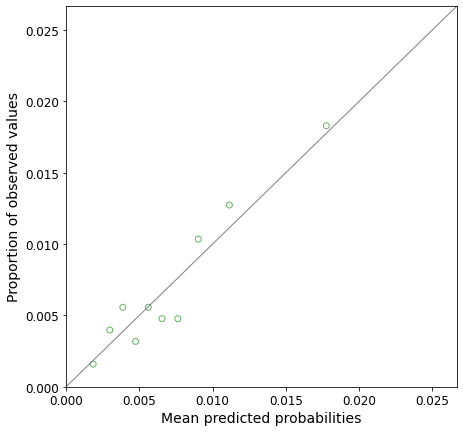

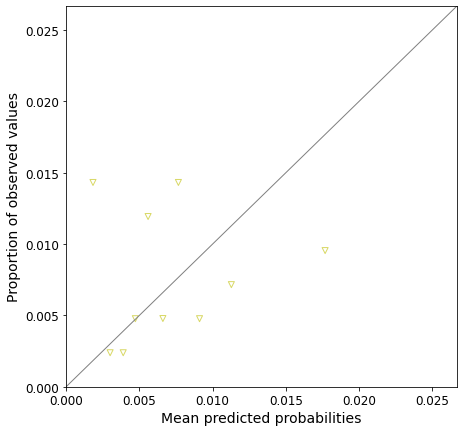

In [40]:
#data prep
data, data_uti_abs_incdt_enc = cox_data_prep(data_uti_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary table
make_summary_table('uti', 'abs_incdt', data_uti_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('uti', 'abs_incdt', data_uti_abs_incdt)

try:
    #build cox model 
    cph_uti_abs_incdt, data_uti_abs_incdt_train, data_uti_abs_incdt_test = cox_model_build('uti', 'abs_incdt', data_uti_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_uti_abs_incdt, '../output/hospitalisation_prediction_uti/', 'betas_cph_uti_abs_incdt.csv', data_uti_abs_incdt_enc, data_uti_abs_incdt, 'sum_betas_cph_uti_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_uti_abs_incdt, 'event_uti_admitted', data_uti_abs_incdt_train, data_uti_abs_incdt_test, '../output/hospitalisation_prediction_uti', 'roc_cph_uti_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_uti_abs_incdt, data_uti_abs_incdt_train, 'event_uti_admitted', data_uti_abs_incdt_test, '../output/hospitalisation_prediction_uti/', 'calibration_cph_uti_abs_incdt_train.jpg', 'calibration_cph_uti_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_uti_abs_incdt, 'uti', 'abs_incdt', data_uti_abs_incdt_train, data_uti_abs_incdt_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent uti with no antibiotics

<lifelines.CoxPHFitter: fitted with 12417 total observations, 12334 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 12417
number of events observed = 83
   partial log-likelihood = -766.33
         time fit was run = 2023-02-02 11:24:19 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.29       0.75       0.35            -0.96             0.39                 0.38                 1.48
CCI_cat[T.medium]                0.08       1.09       0.35            -0.61             0.78                 0.54                 2.17
CCI_cat[T.high]                  0.28       1.32       0.39            -0.49             1.05                 0.61                 2.87
CCI_cat[T.very_high]             0.23       1.26       0.36            -0.48             0.94                 0.62                 2.55
age_cat[T.25_34]                 0.19       1.21       0.43            -0.65             1.03                 0.52                 2.81
age_cat[T.35_44]                -0.12       0.89       0.46            -1.02             0.79                 0.36                 2.19
age_cat[T.45_54]                 0.20       1.22       0.43            -0.64             1.04                 0.53                 2.83
age_cat[T.55_64]                -0.01       0.99       0.45            -0.89             0.87                 0.41                 2.38
age_cat[T.65_74]                 0.30       1.35       0.41            -0.51             1.11                 0.60                 3.05
age_cat[T.75_more]               0.48       1.62       0.40            -0.31             1.27                 0.73                 3.57
antibacterial_brit              -0.03       0.97       0.08            -0.18             0.12                 0.83                 1.13
bmi_cat[T.obese]                -0.45       0.64       0.37            -1.17             0.28                 0.31                 1.32
bmi_cat[T.overweight]           -0.37       0.69       0.47            -1.29             0.56                 0.27                 1.75
bmi_cat[T.underweight]         -16.20       0.00    1691.16         -3330.81          3298.42                 0.00                  inf
bmi_cat[T.unknown]              -0.16       0.86       0.39            -0.91             0.60                 0.40                 1.83
ethnicity[T.unknown]            -0.28       0.76       0.36            -0.98             0.42                 0.38                 1.52
ethnicity[T.white]              -0.12       0.89       0.30            -0.71             0.47                 0.49                 1.60
flu_vaccine[T.yes]              -0.01       0.99       0.37            -0.74             0.72                 0.48                 2.05
imd[T.medium]                    0.32       1.38       0.34            -0.34             0.99                 0.71                 2.69
imd[T.unaffluent]                0.11       1.12       0.36            -0.60             0.81                 0.55                 2.26
imd[T.unknown]                   0.04       1.04       0.56            -1.07             1.14                 0.34                 3.13
imd[T.very_affluent]            -0.08       0.92       0.37            -0.81             0.65                 0.44                 1.91
imd[T.very_unaffluent]          -0.16       0.85       0.38            -0.90             0.59                 0.41                 1.80
region[T.east_midlands]          0.06       1.06       0.39            -0.71             0.83                 0.49                 2.29
region[T.london]                -0.65       0.52       0.39            -

11978


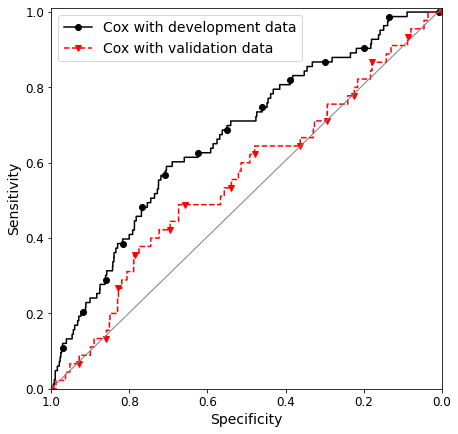

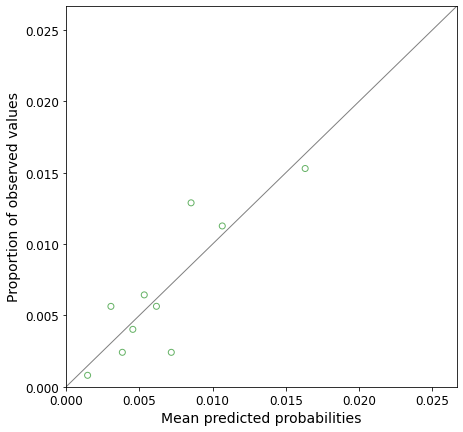

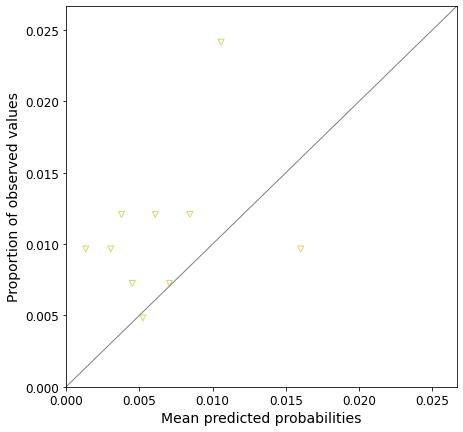

In [41]:
#data prep
data, data_uti_no_abs_prevl_enc = cox_data_prep(data_uti_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary table
make_summary_table('uti', 'no_abs_prevl', data_uti_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('uti', 'no_abs_prevl', data_uti_no_abs_prevl)

try:
    #build cox model 
    cph_uti_no_abs_prevl, data_uti_no_abs_prevl_train, data_uti_no_abs_prevl_test = cox_model_build('uti', 'no_abs_prevl', data_uti_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_uti_no_abs_prevl, '../output/hospitalisation_prediction_uti/', 'betas_cph_uti_no_abs_prevl.csv', data_uti_no_abs_prevl_enc, data_uti_no_abs_prevl, 'sum_betas_cph_uti_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_uti_no_abs_prevl, 'event_uti_admitted', data_uti_no_abs_prevl_train, data_uti_no_abs_prevl_test, '../output/hospitalisation_prediction_uti', 'roc_cph_uti_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_uti_no_abs_prevl, data_uti_no_abs_prevl_train, 'event_uti_admitted', data_uti_no_abs_prevl_test, '../output/hospitalisation_prediction_uti/', 'calibration_cph_uti_no_abs_prevl_train.jpg', 'calibration_cph_uti_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_uti_no_abs_prevl, 'uti', 'no_abs_prevl', data_uti_no_abs_prevl_train, data_uti_no_abs_prevl_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent uti with antibiotics

<lifelines.CoxPHFitter: fitted with 1404 total observations, 1393 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1404
number of events observed = 11
   partial log-likelihood = -64.60
         time fit was run = 2023-02-02 11:24:28 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.60       0.55       0.80            -2.17             0.97                 0.11                 2.64
CCI_cat[T.medium]               -0.32       0.73       0.85            -1.99             1.36                 0.14                 3.89
CCI_cat[T.high]                 -0.76       0.47       1.22            -3.15             1.63                 0.04                 5.11
CCI_cat[T.very_high]           -18.71       0.00    5472.41        -10744.44         10707.02                 0.00                  inf
age_cat[T.25_34]                -0.75       0.47       1.27            -3.25             1.75                 0.04                 5.74
age_cat[T.35_44]                -0.27       0.76       1.05            -2.33             1.78                 0.10                 5.95
age_cat[T.45_54]                -0.63       0.53       1.25            -3.09             1.82                 0.05                 6.18
age_cat[T.55_64]               -18.56       0.00    7233.52        -14195.99         14158.88                 0.00                  inf
age_cat[T.65_74]                -0.61       0.55       1.27            -3.09             1.88                 0.05                 6.52
age_cat[T.75_more]               1.06       2.87       0.91            -0.72             2.83                 0.49                16.97
antibacterial_brit               0.13       1.13       0.23            -0.32             0.57                 0.73                 1.77
bmi_cat[T.obese]                -0.67       0.51       0.86            -2.35             1.01                 0.10                 2.73
bmi_cat[T.overweight]          -18.48       0.00    6703.79        -13157.66         13120.70                 0.00                  inf
bmi_cat[T.underweight]         -18.79       0.00   12109.10        -23752.20         23714.61                 0.00                  inf
bmi_cat[T.unknown]              -0.68       0.51       0.95            -2.54             1.19                 0.08                 3.29
ethnicity[T.unknown]            -0.26       0.77       0.96            -2.15             1.63                 0.12                 5.10
ethnicity[T.white]              -0.33       0.72       0.87            -2.04             1.37                 0.13                 3.95
flu_vaccine[T.yes]              -0.29       0.75       1.12            -2.49             1.91                 0.08                 6.77
imd[T.medium]                    0.51       1.67       0.81            -1.08             2.10                 0.34                 8.17
imd[T.unaffluent]               -1.56       0.21       1.23            -3.98             0.86                 0.02                 2.36
imd[T.unknown]                 -18.31       0.00    9980.56        -19579.85         19543.23                 0.00                  inf
imd[T.very_affluent]            -0.44       0.65       0.97            -2.34             1.46                 0.10                 4.33
imd[T.very_unaffluent]          -0.85       0.43       1.20            -3.20             1.50                 0.04                 4.48
region[T.east_midlands]         17.97   6.39e+07    7679.39        -15033.36         15069.31                 0.00                  inf
region[T.london]                18.12   7.43e+07    7679.39        -15033.21

12180


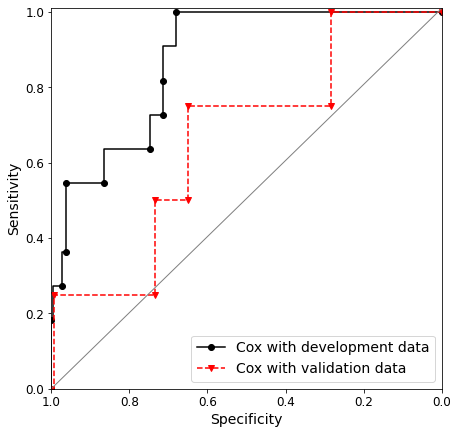

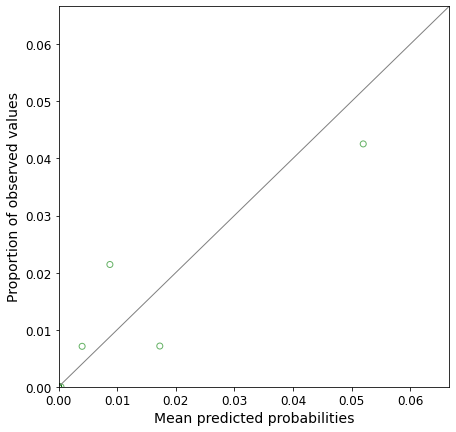

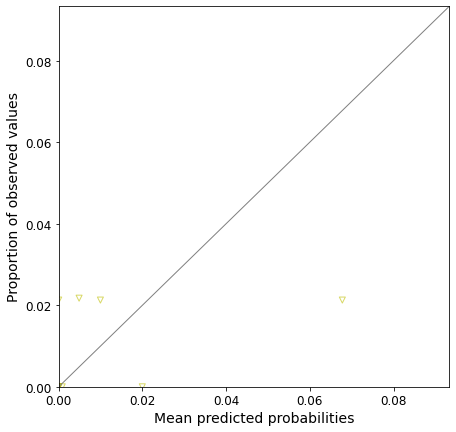

In [42]:
#data prep
data, data_uti_abs_prevl_enc = cox_data_prep(data_uti_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary table
make_summary_table('uti', 'abs_prevl', data_uti_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('uti', 'abs_prevl', data_uti_abs_prevl)

try:
    #build cox model 
    cph_uti_abs_prevl, data_uti_abs_prevl_train, data_uti_abs_prevl_test = cox_model_build('uti', 'abs_prevl', data_uti_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_uti_abs_prevl, '../output/hospitalisation_prediction_uti/', 'betas_cph_uti_abs_prevl.csv', data_uti_abs_prevl_enc, data_uti_abs_prevl, 'sum_betas_cph_uti_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_uti_abs_prevl, 'event_uti_admitted', data_uti_abs_prevl_train, data_uti_abs_prevl_test, '../output/hospitalisation_prediction_uti', 'roc_cph_uti_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_uti_abs_prevl, data_uti_abs_prevl_train, 'event_uti_admitted', data_uti_abs_prevl_test, '../output/hospitalisation_prediction_uti/', 'calibration_cph_uti_abs_prevl_train.jpg', 'calibration_cph_uti_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_uti_abs_prevl, 'uti', 'abs_prevl', data_uti_abs_prevl_train, data_uti_abs_prevl_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident uti

In [43]:
#data prep
data, data_uti_incdt_enc = cox_data_prep(data_uti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary tables from preped data
make_summary_table('uti', 'incdt', data_uti_incdt_enc)
make_summary_table_hosped('uti', 'incdt', data_uti_incdt)

try:
    cph_uti_incdt, data_uti_incdt_train, data_uti_incdt_test = cox_model_abs_build('uti', 'incdt', data_uti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_uti_incdt, 'uti', 'incdt', data_uti_incdt_train, data_uti_incdt_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 125208 total observations, 124275 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 125208
number of events observed = 933
   partial log-likelihood = -10923.62
         time fit was run = 2023-02-02 11:24:40 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.18       1.19       0.10            -0.02             0.38                 0.98                 1.46
CCI_cat[T.medium]                0.20       1.22       0.11            -0.02             0.42                 0.98                 1.52
CCI_cat[T.high]                  0.32       1.37       0.13             0.06             0.57                 1.07                 1.76
CCI_cat[T.very_high]             0.11       1.12       0.12            -0.12             0.35                 0.88                 1.41
age_cat[T.25_34]                -0.11       0.90       0.13            -0.36             0.15                 0.70                 1.16
age_cat[T.35_44]                 0.11       1.11       0.12            -0.13             0.35                 0.87                 1.42
age_cat[T.45_54]                -0.08       0.92       0.13            -0.34             0.17                 0.72                 1.19
age_cat[T.55_64]                 0.20       1.22       0.12            -0.04             0.44                 0.96                 1.55
age_cat[T.65_74]                 0.06       1.06       0.12            -0.18             0.31                 0.83                 1.36
age_cat[T.75_more]               0.19       1.21       0.12            -0.04             0.43                 0.96                 1.54
antibacterial_brit               0.02       1.02       0.02            -0.02             0.07                 0.98                 1.07
bmi_cat[T.obese]                 0.04       1.05       0.13            -0.21             0.29                 0.81                 1.34
bmi_cat[T.overweight]            0.15       1.16       0.15            -0.15             0.44                 0.86                 1.56
bmi_cat[T.underweight]           0.02       1.02       0.22            -0.42             0.45                 0.66                 1.56
bmi_cat[T.unknown]               0.11       1.12       0.13            -0.15             0.37                 0.86                 1.45
ethnicity[T.unknown]             0.25       1.28       0.11             0.02             0.47                 1.02                 1.61
ethnicity[T.white]               0.26       1.30       0.10             0.06             0.47                 1.06                 1.59
flu_vaccine[T.yes]              -0.22       0.81       0.12            -0.45             0.02                 0.64                 1.02
imd[T.medium]                    0.01       1.01       0.11            -0.20             0.22                 0.82                 1.24
imd[T.unaffluent]               -0.05       0.95       0.11            -0.26             0.16                 0.77                 1.18
imd[T.unknown]                   0.10       1.10       0.16            -0.21             0.41                 0.81                 1.51
imd[T.very_affluent]            -0.00       1.00       0.11            -0.21             0.21                 0.81                 1.23
imd[T.very_unaffluent]           0.07       1.07       0.10            -0.14             0.27                 0.87                 1.32
region[T.east_midlands]         -0.06       0.94       0.15            -0.35             0.23                 0.71                 1.26
region[T.london]                 0.12       1.13       0.12       

12200


### 5-6- hospital admission related to prevalent uti

In [44]:
#data prep
data, data_uti_prevl_enc = cox_data_prep(data_uti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary tables from preped data
make_summary_table('uti', 'prevl', data_uti_prevl_enc)
make_summary_table_hosped('uti', 'prevl', data_uti_prevl)

try:
    cph_uti_prevl, data_uti_prevl_train, data_uti_prevl_test = cox_model_abs_build('uti', 'prevl', data_uti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_prevl, 'uti', 'prevl', data_uti_prevl_train, data_uti_prevl_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13821 total observations, 13717 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 13821
number of events observed = 104
   partial log-likelihood = -966.68
         time fit was run = 2023-02-02 11:24:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.27       0.76       0.29            -0.84             0.29                 0.43                 1.34
CCI_cat[T.medium]               -0.06       0.94       0.31            -0.66             0.54                 0.52                 1.71
CCI_cat[T.high]                 -0.03       0.97       0.37            -0.75             0.68                 0.47                 1.98
CCI_cat[T.very_high]            -0.02       0.98       0.32            -0.65             0.61                 0.52                 1.84
age_cat[T.25_34]                -0.10       0.91       0.40            -0.88             0.69                 0.41                 1.99
age_cat[T.35_44]                 0.13       1.14       0.38            -0.62             0.87                 0.54                 2.39
age_cat[T.45_54]                -0.04       0.96       0.40            -0.83             0.75                 0.44                 2.11
age_cat[T.55_64]                 0.13       1.13       0.38            -0.62             0.87                 0.54                 2.39
age_cat[T.65_74]                 0.26       1.29       0.37            -0.47             0.98                 0.63                 2.67
age_cat[T.75_more]               0.45       1.57       0.36            -0.25             1.15                 0.78                 3.15
antibacterial_brit              -0.02       0.98       0.07            -0.16             0.11                 0.85                 1.12
bmi_cat[T.obese]                -0.66       0.52       0.29            -1.23            -0.08                 0.29                 0.92
bmi_cat[T.overweight]           -0.87       0.42       0.42            -1.70            -0.04                 0.18                 0.96
bmi_cat[T.underweight]         -16.43       0.00    1443.53         -2845.71          2812.84                 0.00                  inf
bmi_cat[T.unknown]              -0.56       0.57       0.32            -1.19             0.07                 0.30                 1.07
ethnicity[T.unknown]            -0.48       0.62       0.31            -1.08             0.12                 0.34                 1.12
ethnicity[T.white]              -0.33       0.72       0.25            -0.82             0.17                 0.44                 1.19
flu_vaccine[T.yes]               0.08       1.09       0.32            -0.54             0.71                 0.58                 2.03
imd[T.medium]                    0.57       1.76       0.30            -0.03             1.16                 0.97                 3.20
imd[T.unaffluent]                0.36       1.44       0.32            -0.26             0.99                 0.77                 2.68
imd[T.unknown]                  -0.09       0.91       0.56            -1.18             1.00                 0.31                 2.72
imd[T.very_affluent]            -0.02       0.98       0.34            -0.69             0.65                 0.50                 1.92
imd[T.very_unaffluent]          -0.33       0.72       0.38            -1.07             0.41                 0.34                 1.51
region[T.east_midlands]          0.04       1.04       0.37            -0.68             0.76                 0.51                 2.13
region[T.london]                -0.45       0.63       0.35            

12233


### 5-7- hospital admission related to incident uti with prescribed antibiotics categories

In [45]:
#data prep
data, data_uti_incdt_abs_enc = cox_data_prep(data_uti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_abs, data_uti_incdt_abs_train, data_uti_incdt_abs_test = cox_model_ab_type_build('uti', 'incdt_ab_type', data_uti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_uti_incdt_abs, 'uti', 'incdt_abs', data_uti_incdt_abs_train, data_uti_incdt_abs_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 125208 total observations, 124275 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 125208
number of events observed = 933
   partial log-likelihood = -10922.99
         time fit was run = 2023-02-02 11:25:04 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.18       1.19       0.10            -0.02             0.38                 0.98                 1.46
CCI_cat[T.medium]                0.20       1.22       0.11            -0.02             0.42                 0.98                 1.52
CCI_cat[T.high]                  0.32       1.37       0.13             0.06             0.57                 1.07                 1.76
CCI_cat[T.very_high]             0.11       1.12       0.12            -0.12             0.35                 0.88                 1.41
ab_type_cat[T.Doxycycline]       0.85       2.33       0.76            -0.65             2.34                 0.52                10.41
ab_type_cat[T.no]                0.31       1.36       0.50            -0.67             1.29                 0.51                 3.64
ab_type_cat[T.other]             0.41       1.51       0.51            -0.59             1.41                 0.56                 4.11
age_cat[T.25_34]                -0.11       0.90       0.13            -0.36             0.15                 0.70                 1.16
age_cat[T.35_44]                 0.11       1.11       0.12            -0.14             0.35                 0.87                 1.42
age_cat[T.45_54]                -0.08       0.92       0.13            -0.34             0.17                 0.71                 1.18
age_cat[T.55_64]                 0.20       1.22       0.12            -0.04             0.44                 0.96                 1.55
age_cat[T.65_74]                 0.06       1.06       0.12            -0.18             0.31                 0.83                 1.36
age_cat[T.75_more]               0.19       1.21       0.12            -0.04             0.43                 0.96                 1.54
antibacterial_brit               0.02       1.02       0.02            -0.02             0.07                 0.98                 1.07
bmi_cat[T.obese]                 0.04       1.05       0.13            -0.21             0.29                 0.81                 1.34
bmi_cat[T.overweight]            0.15       1.16       0.15            -0.15             0.44                 0.86                 1.56
bmi_cat[T.underweight]           0.02       1.02       0.22            -0.42             0.45                 0.66                 1.56
bmi_cat[T.unknown]               0.11       1.12       0.13            -0.15             0.37                 0.86                 1.45
ethnicity[T.unknown]             0.25       1.28       0.11             0.02             0.47                 1.03                 1.61
ethnicity[T.white]               0.26       1.30       0.10             0.06             0.47                 1.06                 1.59
flu_vaccine[T.yes]              -0.21       0.81       0.12            -0.45             0.02                 0.64                 1.02
imd[T.medium]                    0.01       1.01       0.11            -0.20             0.22                 0.82                 1.24
imd[T.unaffluent]               -0.05       0.95       0.11            -0.26             0.16                 0.77                 1.18
imd[T.unknown]                   0.10       1.10       0.16            -0.21             0.41                 0.81                 1.51
imd[T.very_affluent]            -0.00       1.00       0.11       

12725


### 5-8- hospital admission related to prevalent uti with prescribed antibiotics categories

In [46]:
#data prep
data, data_uti_prevl_abs_enc = cox_data_prep(data_uti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_abs, data_uti_prevl_abs_train, data_uti_prevl_abs_test = cox_model_ab_type_build('uti', 'prevl_ab_type', data_uti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_uti_prevl_abs, 'uti', 'prevl_abs', data_uti_prevl_abs_train, data_uti_prevl_abs_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13821 total observations, 13717 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 13821
number of events observed = 104
   partial log-likelihood = -964.33
         time fit was run = 2023-02-02 11:25:17 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.27       0.76       0.29            -0.84             0.29                 0.43                 1.34
CCI_cat[T.medium]               -0.06       0.94       0.31            -0.66             0.54                 0.52                 1.71
CCI_cat[T.high]                 -0.05       0.95       0.37            -0.77             0.66                 0.46                 1.94
CCI_cat[T.very_high]            -0.02       0.98       0.32            -0.65             0.61                 0.52                 1.84
ab_type_cat[T.Doxycycline]      17.99   6.51e+07    4563.62         -8926.55          8962.53                 0.00                  inf
ab_type_cat[T.no]               16.32   1.22e+07    4563.62         -8928.22          8960.86                 0.00                  inf
ab_type_cat[T.other]            16.20   1.09e+07    4563.62         -8928.33          8960.74                 0.00                  inf
age_cat[T.25_34]                -0.11       0.90       0.40            -0.90             0.68                 0.41                 1.97
age_cat[T.35_44]                 0.12       1.13       0.38            -0.62             0.87                 0.54                 2.38
age_cat[T.45_54]                -0.05       0.95       0.40            -0.84             0.73                 0.43                 2.08
age_cat[T.55_64]                 0.13       1.13       0.38            -0.62             0.87                 0.54                 2.39
age_cat[T.65_74]                 0.25       1.29       0.37            -0.47             0.98                 0.63                 2.65
age_cat[T.75_more]               0.44       1.55       0.36            -0.26             1.14                 0.77                 3.11
antibacterial_brit              -0.03       0.97       0.07            -0.17             0.11                 0.85                 1.11
bmi_cat[T.obese]                -0.64       0.53       0.29            -1.22            -0.07                 0.30                 0.94
bmi_cat[T.overweight]           -0.83       0.43       0.42            -1.66            -0.00                 0.19                 1.00
bmi_cat[T.underweight]         -16.93       0.00    1881.59         -3704.79          3670.92                 0.00                  inf
bmi_cat[T.unknown]              -0.55       0.58       0.32            -1.17             0.08                 0.31                 1.09
ethnicity[T.unknown]            -0.48       0.62       0.31            -1.08             0.11                 0.34                 1.12
ethnicity[T.white]              -0.34       0.71       0.25            -0.83             0.16                 0.43                 1.17
flu_vaccine[T.yes]               0.08       1.09       0.32            -0.54             0.71                 0.58                 2.03
imd[T.medium]                    0.55       1.73       0.30            -0.05             1.15                 0.95                 3.15
imd[T.unaffluent]                0.37       1.45       0.32            -0.25             1.00                 0.78                 2.71
imd[T.unknown]                  -0.11       0.90       0.56            -1.20             0.98                 0.30                 2.68
imd[T.very_affluent]            -0.03       0.98       0.34            

12798


### 5-9- stratified by sex
#### 5-9-1- incident males

In [47]:
#data prep
data, data_uti_incdt_males_enc = cox_data_prep(data_uti_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_males, data_uti_incdt_males_train, data_uti_incdt_males_test = cox_model_strat_sex_build('uti', 'incdt_males', data_uti_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_uti_incdt_males, 'uti', 'incdt_males', data_uti_incdt_males_train, data_uti_incdt_males_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 61363 total observations, 60902 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 61363
number of events observed = 461
   partial log-likelihood = -5062.05
         time fit was run = 2023-02-02 11:25:20 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.21       1.23       0.15            -0.07             0.50                 0.93                 1.64
CCI_cat[T.medium]                0.12       1.12       0.16            -0.20             0.43                 0.82                 1.54
CCI_cat[T.high]                  0.39       1.48       0.18             0.04             0.74                 1.04                 2.10
CCI_cat[T.very_high]             0.13       1.14       0.17            -0.20             0.46                 0.82                 1.59
age_cat[T.25_34]                -0.16       0.85       0.18            -0.52             0.19                 0.59                 1.21
age_cat[T.35_44]                 0.01       1.01       0.17            -0.34             0.35                 0.72                 1.42
age_cat[T.45_54]                 0.03       1.03       0.17            -0.31             0.37                 0.73                 1.45
age_cat[T.55_64]                 0.19       1.21       0.17            -0.14             0.52                 0.87                 1.68
age_cat[T.65_74]                 0.10       1.11       0.17            -0.23             0.44                 0.79                 1.55
age_cat[T.75_more]              -0.06       0.94       0.18            -0.41             0.29                 0.66                 1.33
antibacterial_brit              -0.03       0.97       0.03            -0.10             0.03                 0.91                 1.03
bmi_cat[T.obese]                -0.04       0.96       0.18            -0.39             0.31                 0.68                 1.36
bmi_cat[T.overweight]            0.28       1.32       0.21            -0.12             0.68                 0.88                 1.98
bmi_cat[T.underweight]           0.02       1.02       0.31            -0.58             0.62                 0.56                 1.85
bmi_cat[T.unknown]               0.05       1.05       0.19            -0.32             0.42                 0.72                 1.51
ethnicity[T.unknown]             0.13       1.14       0.16            -0.19             0.45                 0.83                 1.57
ethnicity[T.white]               0.26       1.30       0.14            -0.02             0.54                 0.98                 1.72
flu_vaccine[T.yes]              -0.42       0.66       0.18            -0.78            -0.06                 0.46                 0.94
imd[T.medium]                   -0.11       0.89       0.16            -0.42             0.20                 0.66                 1.22
imd[T.unaffluent]                0.02       1.02       0.15            -0.28             0.32                 0.76                 1.37
imd[T.unknown]                   0.12       1.12       0.23            -0.33             0.56                 0.72                 1.75
imd[T.very_affluent]             0.06       1.06       0.15            -0.24             0.35                 0.79                 1.42
imd[T.very_unaffluent]           0.11       1.11       0.15            -0.18             0.40                 0.83                 1.49
region[T.east_midlands]          0.13       1.14       0.21            -0.28             0.55                 0.76                 1.72
region[T.london]                 0.04       1.04       0.19           

11948


#### 5-9-2- incident females

In [48]:
#data prep
data, data_uti_incdt_females_enc = cox_data_prep(data_uti_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_females, data_uti_incdt_females_train, data_uti_incdt_females_test = cox_model_strat_sex_build('uti', 'incdt_females', data_uti_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_incdt_females, 'uti', 'incdt_females', data_uti_incdt_females_train, data_uti_incdt_females_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 63845 total observations, 63348 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 63845
number of events observed = 497
   partial log-likelihood = -5479.17
         time fit was run = 2023-02-02 11:25:27 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.10       1.10       0.13            -0.17             0.36                 0.85                 1.43
CCI_cat[T.medium]                0.05       1.06       0.15            -0.24             0.35                 0.79                 1.41
CCI_cat[T.high]                  0.15       1.16       0.17            -0.19             0.48                 0.83                 1.62
CCI_cat[T.very_high]            -0.14       0.87       0.16            -0.46             0.18                 0.63                 1.20
age_cat[T.25_34]                 0.20       1.22       0.18            -0.15             0.55                 0.86                 1.73
age_cat[T.35_44]                 0.20       1.22       0.18            -0.15             0.55                 0.86                 1.73
age_cat[T.45_54]                 0.18       1.20       0.18            -0.17             0.53                 0.85                 1.71
age_cat[T.55_64]                 0.16       1.17       0.18            -0.20             0.51                 0.82                 1.67
age_cat[T.65_74]                 0.33       1.39       0.17            -0.01             0.67                 0.99                 1.95
age_cat[T.75_more]               0.33       1.40       0.17            -0.01             0.67                 0.99                 1.96
antibacterial_brit               0.01       1.01       0.03            -0.05             0.08                 0.95                 1.08
bmi_cat[T.obese]                 0.28       1.33       0.19            -0.09             0.66                 0.92                 1.93
bmi_cat[T.overweight]            0.31       1.36       0.22            -0.12             0.74                 0.88                 2.10
bmi_cat[T.underweight]           0.51       1.66       0.28            -0.04             1.06                 0.96                 2.90
bmi_cat[T.unknown]               0.20       1.23       0.20            -0.19             0.60                 0.82                 1.82
ethnicity[T.unknown]             0.25       1.28       0.15            -0.05             0.55                 0.95                 1.73
ethnicity[T.white]               0.16       1.18       0.14            -0.11             0.44                 0.90                 1.55
flu_vaccine[T.yes]              -0.13       0.88       0.16            -0.44             0.18                 0.64                 1.20
imd[T.medium]                    0.10       1.11       0.14            -0.18             0.39                 0.84                 1.47
imd[T.unaffluent]               -0.16       0.85       0.15            -0.46             0.15                 0.63                 1.16
imd[T.unknown]                   0.11       1.12       0.22            -0.32             0.54                 0.73                 1.72
imd[T.very_affluent]             0.09       1.10       0.14            -0.19             0.37                 0.83                 1.45
imd[T.very_unaffluent]           0.02       1.02       0.15            -0.27             0.30                 0.77                 1.36
region[T.east_midlands]         -0.12       0.89       0.20            -0.52             0.28                 0.59                 1.32
region[T.london]                 0.19       1.21       0.17           

11950


#### 5-9-3- prevalent males

In [49]:
#data prep
data, data_uti_prevl_males_enc = cox_data_prep(data_uti_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_males, data_uti_prevl_males_train, data_uti_prevl_males_test = cox_model_strat_sex_build('uti', 'prevl_males', data_uti_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cox_output(cph_uti_prevl_males, 'uti', 'prevl_males', data_uti_prevl_males_train, data_uti_prevl_males_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6681 total observations, 6633 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 6681
number of events observed = 48
   partial log-likelihood = -406.15
         time fit was run = 2023-02-02 11:25:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.53       0.59       0.39            -1.29             0.23                 0.27                 1.26
CCI_cat[T.medium]               -0.52       0.59       0.44            -1.39             0.35                 0.25                 1.42
CCI_cat[T.high]                 -0.69       0.50       0.58            -1.83             0.44                 0.16                 1.55
CCI_cat[T.very_high]            -0.39       0.68       0.46            -1.28             0.51                 0.28                 1.67
age_cat[T.25_34]                 1.32       3.74       0.65             0.04             2.60                 1.04                13.45
age_cat[T.35_44]                 0.65       1.91       0.71            -0.74             2.04                 0.48                 7.67
age_cat[T.45_54]                 0.77       2.15       0.71            -0.62             2.16                 0.54                 8.64
age_cat[T.55_64]                 0.43       1.53       0.73            -1.01             1.86                 0.36                 6.44
age_cat[T.65_74]                 0.92       2.50       0.68            -0.41             2.24                 0.66                 9.44
age_cat[T.75_more]               1.09       2.96       0.67            -0.22             2.40                 0.80                10.98
antibacterial_brit               0.17       1.19       0.10            -0.01             0.36                 0.99                 1.44
bmi_cat[T.obese]                -0.40       0.67       0.46            -1.30             0.49                 0.27                 1.64
bmi_cat[T.overweight]           -1.10       0.33       0.71            -2.49             0.29                 0.08                 1.33
bmi_cat[T.underweight]         -16.35       0.00    2401.67         -4723.54          4690.83                 0.00                  inf
bmi_cat[T.unknown]              -0.28       0.76       0.49            -1.24             0.68                 0.29                 1.98
ethnicity[T.unknown]            -0.15       0.86       0.42            -0.96             0.67                 0.38                 1.95
ethnicity[T.white]              -0.49       0.61       0.38            -1.23             0.25                 0.29                 1.29
flu_vaccine[T.yes]               0.43       1.54       0.41            -0.38             1.24                 0.69                 3.44
imd[T.medium]                   -0.54       0.58       0.45            -1.41             0.33                 0.24                 1.40
imd[T.unaffluent]               -0.62       0.54       0.47            -1.53             0.30                 0.22                 1.35
imd[T.unknown]                  -0.49       0.61       0.76            -1.98             1.00                 0.14                 2.71
imd[T.very_affluent]            -0.66       0.52       0.47            -1.57             0.26                 0.21                 1.29
imd[T.very_unaffluent]          -0.29       0.75       0.42            -1.10             0.53                 0.33                 1.70
region[T.east_midlands]          0.32       1.38       0.51            -0.67             1.32                 0.51                 3.73
region[T.london]                -0.43       0.65       0.51            -1.4

11983


#### 5-9-4- prevalent females

In [50]:
try:
    #data prep
    data, data_uti_prevl_females_enc = cox_data_prep(data_uti_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

    #cox model
    cph_uti_prevl_females, data_uti_prevl_females_train, data_uti_prevl_females_test = cox_model_strat_sex_build('uti', 'prevl_females', data_uti_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_uti_prevl_females, 'uti', 'prevl_females', data_uti_prevl_females_train, data_uti_prevl_females_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7140 total observations, 7094 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 7140
number of events observed = 46
   partial log-likelihood = -391.20
         time fit was run = 2023-02-02 11:25:35 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.62       1.85       0.56            -0.49             1.72                 0.61                 5.61
CCI_cat[T.medium]                0.92       2.51       0.58            -0.22             2.06                 0.80                 7.81
CCI_cat[T.high]                  1.05       2.86       0.63            -0.18             2.28                 0.83                 9.82
CCI_cat[T.very_high]             0.82       2.27       0.61            -0.39             2.02                 0.68                 7.56
age_cat[T.25_34]                 0.55       1.74       0.73            -0.88             1.99                 0.41                 7.29
age_cat[T.35_44]                 1.19       3.30       0.67            -0.12             2.50                 0.89                12.22
age_cat[T.45_54]                 0.84       2.32       0.71            -0.54             2.23                 0.58                 9.32
age_cat[T.55_64]                 1.21       3.36       0.67            -0.10             2.52                 0.91                12.44
age_cat[T.65_74]                 0.90       2.46       0.69            -0.45             2.26                 0.64                 9.56
age_cat[T.75_more]               0.97       2.63       0.69            -0.39             2.32                 0.68                10.18
antibacterial_brit              -0.05       0.95       0.11            -0.26             0.16                 0.77                 1.17
bmi_cat[T.obese]                -0.88       0.42       0.44            -1.74            -0.02                 0.18                 0.98
bmi_cat[T.overweight]           -0.78       0.46       0.59            -1.94             0.37                 0.14                 1.45
bmi_cat[T.underweight]          -1.13       0.32       1.07            -3.23             0.97                 0.04                 2.64
bmi_cat[T.unknown]              -0.67       0.51       0.48            -1.61             0.27                 0.20                 1.30
ethnicity[T.unknown]            -0.86       0.42       0.48            -1.79             0.07                 0.17                 1.08
ethnicity[T.white]              -0.45       0.64       0.37            -1.18             0.28                 0.31                 1.32
flu_vaccine[T.yes]               0.14       1.15       0.48            -0.79             1.07                 0.45                 2.92
imd[T.medium]                    0.68       1.97       0.50            -0.31             1.66                 0.74                 5.27
imd[T.unaffluent]                0.78       2.19       0.50            -0.19             1.76                 0.83                 5.78
imd[T.unknown]                 -16.51       0.00    2973.98         -5845.40          5812.38                 0.00                  inf
imd[T.very_affluent]             0.28       1.32       0.54            -0.79             1.34                 0.46                 3.81
imd[T.very_unaffluent]           0.08       1.08       0.56            -1.01             1.17                 0.36                 3.23
region[T.east_midlands]          0.92       2.50       0.69            -0.44             2.27                 0.65                 9.72
region[T.london]                 0.44       1.56       0.67            -0.8

11955


### 5-10- stratified by age category
#### 5-10-1- incident

In [51]:
#data prep
data, data_uti_incdt_15_24_enc = cox_data_prep(data_uti_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_15_24, data_uti_incdt_15_24_train, data_uti_incdt_15_24_test = cox_model_strat_age_build('uti', 'incdt_15_24', data_uti_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_incdt_15_24, 'uti', 'incdt_15_24', data_uti_incdt_15_24_train, data_uti_incdt_15_24_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17928 total observations, 17806 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 17928
number of events observed = 122
   partial log-likelihood = -1168.06
         time fit was run = 2023-02-02 11:25:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.43       1.54       0.32            -0.19             1.06                 0.83                 2.88
CCI_cat[T.medium]                0.35       1.42       0.35            -0.34             1.03                 0.71                 2.81
CCI_cat[T.high]                  0.67       1.95       0.37            -0.06             1.40                 0.94                 4.07
CCI_cat[T.very_high]             0.82       2.28       0.33             0.17             1.48                 1.18                 4.38
antibacterial_brit              -0.11       0.90       0.07            -0.24             0.02                 0.79                 1.02
bmi_cat[T.obese]                 0.26       1.30       0.40            -0.52             1.05                 0.59                 2.85
bmi_cat[T.overweight]            0.92       2.51       0.43             0.08             1.76                 1.08                 5.84
bmi_cat[T.underweight]           0.15       1.17       0.69            -1.20             1.51                 0.30                 4.52
bmi_cat[T.unknown]               0.27       1.31       0.42            -0.56             1.09                 0.57                 2.98
ethnicity[T.unknown]             0.58       1.78       0.31            -0.03             1.18                 0.97                 3.27
ethnicity[T.white]               0.19       1.21       0.29            -0.38             0.77                 0.68                 2.16
flu_vaccine[T.yes]              -1.00       0.37       0.46            -1.89            -0.10                 0.15                 0.90
imd[T.medium]                   -0.20       0.82       0.31            -0.82             0.41                 0.44                 1.51
imd[T.unaffluent]                0.07       1.07       0.29            -0.50             0.65                 0.60                 1.91
imd[T.unknown]                   0.57       1.77       0.37            -0.16             1.30                 0.86                 3.66
imd[T.very_affluent]            -0.21       0.81       0.31            -0.82             0.40                 0.44                 1.50
imd[T.very_unaffluent]           0.13       1.13       0.29            -0.44             0.69                 0.64                 2.00
region[T.east_midlands]         -0.27       0.76       0.41            -1.08             0.54                 0.34                 1.72
region[T.london]                 0.24       1.27       0.32            -0.38             0.87                 0.68                 2.38
region[T.north_east]            -0.53       0.59       0.44            -1.40             0.34                 0.25                 1.40
region[T.north_west]            -0.01       0.99       0.39            -0.76             0.75                 0.47                 2.12
region[T.south_east]            -0.19       0.83       0.39            -0.96             0.58                 0.38                 1.79
region[T.south_west]            -0.22       0.80       0.40            -1.01             0.57                 0.36                 1.77
region[T.west_midlands]         -0.56       0.57       0.44            -1.43             0.31                 0.24                 1.36
region[T.yorkshire]             -0.10       0.90       0.39           

10683


In [52]:
#data prep
data, data_uti_incdt_25_34_enc = cox_data_prep(data_uti_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_25_34, data_uti_incdt_25_34_train, data_uti_incdt_25_34_test = cox_model_strat_age_build('uti', 'incdt_25_34', data_uti_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_incdt_25_34, 'uti', 'incdt_25_34', data_uti_incdt_25_34_train, data_uti_incdt_25_34_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 18145 total observations, 18026 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 18145
number of events observed = 119
   partial log-likelihood = -1154.11
         time fit was run = 2023-02-02 11:25:41 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.66       1.94       0.32             0.03             1.29                 1.03                 3.65
CCI_cat[T.medium]                0.64       1.90       0.35            -0.03             1.32                 0.97                 3.74
CCI_cat[T.high]                  0.59       1.81       0.40            -0.19             1.38                 0.83                 3.97
CCI_cat[T.very_high]             0.46       1.58       0.37            -0.26             1.18                 0.77                 3.26
antibacterial_brit               0.09       1.09       0.06            -0.04             0.21                 0.96                 1.23
bmi_cat[T.obese]                -0.17       0.85       0.31            -0.78             0.45                 0.46                 1.57
bmi_cat[T.overweight]           -0.44       0.64       0.42            -1.26             0.38                 0.28                 1.46
bmi_cat[T.underweight]          -0.24       0.78       0.58            -1.38             0.89                 0.25                 2.44
bmi_cat[T.unknown]              -0.30       0.74       0.35            -0.98             0.39                 0.38                 1.47
ethnicity[T.unknown]             0.07       1.07       0.30            -0.53             0.66                 0.59                 1.94
ethnicity[T.white]               0.07       1.07       0.27            -0.46             0.60                 0.63                 1.82
flu_vaccine[T.yes]              -0.45       0.64       0.37            -1.17             0.27                 0.31                 1.31
imd[T.medium]                   -0.14       0.87       0.28            -0.69             0.41                 0.50                 1.51
imd[T.unaffluent]               -0.47       0.62       0.31            -1.08             0.14                 0.34                 1.15
imd[T.unknown]                  -0.60       0.55       0.54            -1.65             0.46                 0.19                 1.58
imd[T.very_affluent]            -0.05       0.95       0.28            -0.59             0.50                 0.55                 1.64
imd[T.very_unaffluent]          -0.24       0.78       0.29            -0.81             0.32                 0.45                 1.38
region[T.east_midlands]         -0.21       0.81       0.41            -1.02             0.59                 0.36                 1.81
region[T.london]                 0.08       1.08       0.33            -0.58             0.73                 0.56                 2.08
region[T.north_east]            -0.55       0.58       0.45            -1.43             0.33                 0.24                 1.39
region[T.north_west]             0.05       1.06       0.39            -0.72             0.82                 0.49                 2.28
region[T.south_east]            -0.41       0.66       0.43            -1.26             0.44                 0.28                 1.56
region[T.south_west]            -0.03       0.97       0.39            -0.80             0.74                 0.45                 2.09
region[T.west_midlands]          0.04       1.04       0.39            -0.72             0.79                 0.49                 2.21
region[T.yorkshire]             -0.35       0.71       0.43           

10695


In [53]:
#data prep
data, data_uti_incdt_35_44_enc = cox_data_prep(data_uti_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_35_44, data_uti_incdt_35_44_train, data_uti_incdt_35_44_test = cox_model_strat_age_build('uti', 'incdt_35_44', data_uti_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_incdt_35_44, 'uti', 'incdt_35_44', data_uti_incdt_35_44_train, data_uti_incdt_35_44_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17937 total observations, 17810 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 17937
number of events observed = 127
   partial log-likelihood = -1224.93
         time fit was run = 2023-02-02 11:25:45 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.12       1.13       0.27            -0.40             0.65                 0.67                 1.91
CCI_cat[T.medium]                0.12       1.13       0.29            -0.46             0.69                 0.63                 2.00
CCI_cat[T.high]                  0.18       1.20       0.34            -0.49             0.85                 0.61                 2.35
CCI_cat[T.very_high]            -0.15       0.86       0.33            -0.80             0.50                 0.45                 1.65
antibacterial_brit              -0.00       1.00       0.06            -0.12             0.12                 0.88                 1.13
bmi_cat[T.obese]                -0.30       0.74       0.30            -0.90             0.30                 0.41                 1.35
bmi_cat[T.overweight]           -0.62       0.54       0.42            -1.45             0.20                 0.24                 1.23
bmi_cat[T.underweight]          -1.59       0.20       1.04            -3.63             0.44                 0.03                 1.56
bmi_cat[T.unknown]              -0.14       0.87       0.32            -0.78             0.49                 0.46                 1.63
ethnicity[T.unknown]             0.09       1.09       0.30            -0.50             0.68                 0.60                 1.97
ethnicity[T.white]               0.16       1.18       0.27            -0.36             0.69                 0.70                 1.99
flu_vaccine[T.yes]               0.03       1.03       0.29            -0.54             0.61                 0.58                 1.83
imd[T.medium]                    0.41       1.50       0.28            -0.15             0.96                 0.86                 2.61
imd[T.unaffluent]                0.14       1.15       0.30            -0.45             0.72                 0.64                 2.05
imd[T.unknown]                   0.49       1.63       0.40            -0.29             1.27                 0.75                 3.57
imd[T.very_affluent]            -0.08       0.92       0.31            -0.70             0.53                 0.50                 1.70
imd[T.very_unaffluent]          -0.08       0.92       0.31            -0.69             0.52                 0.50                 1.69
region[T.east_midlands]          0.98       2.66       0.42             0.16             1.79                 1.18                 6.01
region[T.london]                 0.75       2.12       0.39            -0.02             1.52                 0.98                 4.58
region[T.north_east]             0.56       1.75       0.44            -0.31             1.43                 0.73                 4.17
region[T.north_west]            -0.48       0.62       0.57            -1.60             0.64                 0.20                 1.89
region[T.south_east]             0.29       1.34       0.47            -0.62             1.21                 0.54                 3.34
region[T.south_west]             0.31       1.36       0.47            -0.60             1.22                 0.55                 3.39
region[T.west_midlands]          0.44       1.55       0.46            -0.46             1.33                 0.63                 3.79
region[T.yorkshire]              0.37       1.45       0.47           

10679


In [54]:
#data prep
data, data_uti_incdt_45_54_enc = cox_data_prep(data_uti_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_45_54, data_uti_incdt_45_54_train, data_uti_incdt_45_54_test = cox_model_strat_age_build('uti', 'incdt_45_54', data_uti_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_incdt_45_54, 'uti', 'incdt_45_54', data_uti_incdt_45_54_train, data_uti_incdt_45_54_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17900 total observations, 17775 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 17900
number of events observed = 125
   partial log-likelihood = -1205.96
         time fit was run = 2023-02-02 11:25:47 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.33       1.39       0.29            -0.24             0.90                 0.79                 2.46
CCI_cat[T.medium]                0.25       1.28       0.31            -0.37             0.86                 0.69                 2.37
CCI_cat[T.high]                  0.46       1.58       0.35            -0.23             1.14                 0.80                 3.13
CCI_cat[T.very_high]            -0.04       0.96       0.35            -0.72             0.65                 0.49                 1.91
antibacterial_brit              -0.13       0.88       0.07            -0.26             0.01                 0.77                 1.01
bmi_cat[T.obese]                 0.70       2.02       0.46            -0.21             1.61                 0.81                 5.02
bmi_cat[T.overweight]            1.13       3.08       0.50             0.15             2.10                 1.16                 8.18
bmi_cat[T.underweight]           1.11       3.03       0.61            -0.08             2.30                 0.92                 9.95
bmi_cat[T.unknown]               0.46       1.59       0.49            -0.50             1.42                 0.61                 4.15
ethnicity[T.unknown]             0.22       1.25       0.30            -0.37             0.81                 0.69                 2.26
ethnicity[T.white]               0.16       1.17       0.28            -0.39             0.70                 0.68                 2.01
flu_vaccine[T.yes]              -0.12       0.89       0.32            -0.74             0.50                 0.48                 1.65
imd[T.medium]                    0.42       1.53       0.29            -0.14             0.99                 0.87                 2.69
imd[T.unaffluent]                0.13       1.14       0.31            -0.48             0.73                 0.62                 2.08
imd[T.unknown]                  -0.28       0.76       0.55            -1.35             0.80                 0.26                 2.22
imd[T.very_affluent]            -0.11       0.90       0.33            -0.75             0.53                 0.47                 1.70
imd[T.very_unaffluent]           0.41       1.51       0.29            -0.15             0.97                 0.86                 2.65
region[T.east_midlands]         -0.17       0.84       0.45            -1.06             0.71                 0.35                 2.03
region[T.london]                 0.44       1.56       0.35            -0.24             1.12                 0.79                 3.08
region[T.north_east]             0.25       1.29       0.40            -0.54             1.04                 0.58                 2.84
region[T.north_west]             0.16       1.17       0.41            -0.65             0.96                 0.52                 2.61
region[T.south_east]            -0.04       0.96       0.44            -0.89             0.82                 0.41                 2.27
region[T.south_west]            -0.06       0.94       0.44            -0.92             0.80                 0.40                 2.22
region[T.west_midlands]          0.41       1.51       0.39            -0.36             1.18                 0.70                 3.25
region[T.yorkshire]             -0.29       0.75       0.47           

10679


In [55]:
#data prep
data, data_uti_incdt_55_64_enc = cox_data_prep(data_uti_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_55_64, data_uti_incdt_55_64_train, data_uti_incdt_55_64_test = cox_model_strat_age_build('uti', 'incdt_55_64', data_uti_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_incdt_55_64, 'uti', 'incdt_55_64', data_uti_incdt_55_64_train, data_uti_incdt_55_64_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17492 total observations, 17346 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 17492
number of events observed = 146
   partial log-likelihood = -1411.47
         time fit was run = 2023-02-02 11:25:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.21       1.23       0.25            -0.27             0.69                 0.76                 1.99
CCI_cat[T.medium]               -0.15       0.86       0.29            -0.72             0.42                 0.49                 1.53
CCI_cat[T.high]                  0.24       1.28       0.32            -0.38             0.87                 0.68                 2.39
CCI_cat[T.very_high]             0.05       1.05       0.30            -0.54             0.63                 0.58                 1.88
antibacterial_brit              -0.04       0.96       0.06            -0.16             0.07                 0.85                 1.08
bmi_cat[T.obese]                 0.34       1.41       0.35            -0.35             1.03                 0.71                 2.81
bmi_cat[T.overweight]            0.50       1.65       0.40            -0.28             1.29                 0.75                 3.64
bmi_cat[T.underweight]          -0.16       0.85       0.67            -1.47             1.14                 0.23                 3.14
bmi_cat[T.unknown]               0.28       1.32       0.37            -0.45             1.01                 0.64                 2.75
ethnicity[T.unknown]             0.12       1.12       0.32            -0.51             0.74                 0.60                 2.09
ethnicity[T.white]               0.54       1.71       0.28            -0.00             1.08                 1.00                 2.95
flu_vaccine[T.yes]              -0.35       0.71       0.33            -0.99             0.29                 0.37                 1.34
imd[T.medium]                    0.02       1.02       0.27            -0.51             0.55                 0.60                 1.74
imd[T.unaffluent]               -0.01       0.99       0.27            -0.54             0.52                 0.58                 1.67
imd[T.unknown]                   0.04       1.04       0.42            -0.79             0.87                 0.45                 2.39
imd[T.very_affluent]             0.20       1.22       0.26            -0.32             0.71                 0.73                 2.03
imd[T.very_unaffluent]          -0.11       0.89       0.28            -0.66             0.43                 0.52                 1.54
region[T.east_midlands]         -0.40       0.67       0.39            -1.16             0.36                 0.31                 1.43
region[T.london]                -0.24       0.79       0.31            -0.85             0.38                 0.43                 1.46
region[T.north_east]             0.20       1.23       0.33            -0.45             0.86                 0.64                 2.36
region[T.north_west]            -0.01       0.99       0.34            -0.68             0.66                 0.51                 1.94
region[T.south_east]            -0.25       0.78       0.37            -0.97             0.48                 0.38                 1.61
region[T.south_west]            -0.16       0.86       0.36            -0.86             0.55                 0.42                 1.74
region[T.west_midlands]          0.04       1.05       0.34            -0.62             0.71                 0.54                 2.03
region[T.yorkshire]             -0.41       0.67       0.39           

10688


In [56]:
#data prep
data, data_uti_incdt_65_74_enc = cox_data_prep(data_uti_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_65_74, data_uti_incdt_65_74_train, data_uti_incdt_65_74_test = cox_model_strat_age_build('uti', 'incdt_65_74', data_uti_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_incdt_65_74, 'uti', 'incdt_65_74', data_uti_incdt_65_74_train, data_uti_incdt_65_74_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 18108 total observations, 17971 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 18108
number of events observed = 137
   partial log-likelihood = -1329.29
         time fit was run = 2023-02-02 11:25:52 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.05       1.05       0.26            -0.46             0.56                 0.63                 1.76
CCI_cat[T.medium]                0.18       1.20       0.28            -0.37             0.74                 0.69                 2.09
CCI_cat[T.high]                  0.22       1.25       0.33            -0.42             0.86                 0.66                 2.37
CCI_cat[T.very_high]            -0.15       0.86       0.32            -0.77             0.48                 0.46                 1.61
antibacterial_brit               0.12       1.13       0.06             0.01             0.23                 1.01                 1.26
bmi_cat[T.obese]                 0.26       1.29       0.35            -0.44             0.95                 0.65                 2.59
bmi_cat[T.overweight]            0.21       1.23       0.42            -0.62             1.03                 0.54                 2.81
bmi_cat[T.underweight]           0.04       1.04       0.60            -1.14             1.22                 0.32                 3.37
bmi_cat[T.unknown]               0.29       1.34       0.37            -0.44             1.02                 0.64                 2.77
ethnicity[T.unknown]            -0.04       0.96       0.29            -0.61             0.54                 0.54                 1.71
ethnicity[T.white]               0.12       1.13       0.25            -0.38             0.62                 0.69                 1.86
flu_vaccine[T.yes]              -0.14       0.87       0.30            -0.73             0.45                 0.48                 1.57
imd[T.medium]                   -0.22       0.80       0.30            -0.81             0.37                 0.44                 1.45
imd[T.unaffluent]               -0.14       0.87       0.30            -0.73             0.44                 0.48                 1.56
imd[T.unknown]                   0.30       1.36       0.39            -0.46             1.07                 0.63                 2.92
imd[T.very_affluent]             0.08       1.08       0.28            -0.47             0.62                 0.63                 1.86
imd[T.very_unaffluent]           0.31       1.36       0.27            -0.21             0.83                 0.81                 2.29
region[T.east_midlands]          0.09       1.10       0.34            -0.58             0.77                 0.56                 2.15
region[T.london]                -0.19       0.83       0.32            -0.81             0.43                 0.45                 1.54
region[T.north_east]            -0.35       0.70       0.38            -1.10             0.40                 0.33                 1.49
region[T.north_west]            -0.30       0.74       0.38            -1.05             0.45                 0.35                 1.57
region[T.south_east]             0.06       1.06       0.34            -0.61             0.74                 0.54                 2.09
region[T.south_west]            -0.66       0.52       0.42            -1.47             0.16                 0.23                 1.18
region[T.west_midlands]         -0.50       0.61       0.40            -1.29             0.29                 0.28                 1.34
region[T.yorkshire]             -0.16       0.85       0.36           

10694


In [57]:
#data prep
data, data_uti_incdt_75_more_enc = cox_data_prep(data_uti_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_75_more, data_uti_incdt_75_more_train, data_uti_incdt_75_more_test = cox_model_strat_age_build('uti', 'incdt_75_more', data_uti_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_incdt_75_more, 'uti', 'incdt_75_more', data_uti_incdt_75_more_train, data_uti_incdt_75_more_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17696 total observations, 17559 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 17696
number of events observed = 137
   partial log-likelihood = -1316.24
         time fit was run = 2023-02-02 11:25:56 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.28       1.33       0.29            -0.29             0.85                 0.75                 2.35
CCI_cat[T.medium]                0.48       1.62       0.30            -0.11             1.08                 0.89                 2.95
CCI_cat[T.high]                  0.29       1.34       0.37            -0.43             1.01                 0.65                 2.74
CCI_cat[T.very_high]             0.57       1.78       0.31            -0.04             1.19                 0.96                 3.27
antibacterial_brit              -0.01       0.99       0.06            -0.13             0.11                 0.88                 1.11
bmi_cat[T.obese]                 0.96       2.62       0.51            -0.05             1.97                 0.96                 7.19
bmi_cat[T.overweight]            0.94       2.57       0.56            -0.16             2.05                 0.85                 7.74
bmi_cat[T.underweight]           0.91       2.49       0.71            -0.48             2.30                 0.62                 9.94
bmi_cat[T.unknown]               1.35       3.86       0.52             0.33             2.37                 1.39                10.73
ethnicity[T.unknown]             0.89       2.45       0.34             0.23             1.56                 1.26                 4.75
ethnicity[T.white]               0.71       2.03       0.32             0.08             1.34                 1.08                 3.80
flu_vaccine[T.yes]              -0.14       0.87       0.30            -0.74             0.45                 0.48                 1.57
imd[T.medium]                    0.07       1.08       0.28            -0.47             0.62                 0.62                 1.86
imd[T.unaffluent]               -0.02       0.98       0.29            -0.58             0.54                 0.56                 1.72
imd[T.unknown]                   0.01       1.01       0.43            -0.83             0.85                 0.44                 2.34
imd[T.very_affluent]            -0.01       0.99       0.28            -0.56             0.55                 0.57                 1.73
imd[T.very_unaffluent]           0.18       1.20       0.27            -0.35             0.72                 0.70                 2.05
region[T.east_midlands]         -0.29       0.75       0.42            -1.11             0.54                 0.33                 1.72
region[T.london]                 0.10       1.11       0.33            -0.55             0.75                 0.58                 2.13
region[T.north_east]             0.49       1.63       0.35            -0.19             1.17                 0.83                 3.23
region[T.north_west]             0.14       1.15       0.38            -0.61             0.88                 0.54                 2.41
region[T.south_east]             0.16       1.17       0.37            -0.58             0.89                 0.56                 2.43
region[T.south_west]             0.13       1.14       0.37            -0.60             0.86                 0.55                 2.37
region[T.west_midlands]         -0.68       0.51       0.47            -1.60             0.24                 0.20                 1.27
region[T.yorkshire]             -0.63       0.53       0.47           

10672


#### 5-10-2- prevalent

In [58]:
#data prep
data, data_uti_prevl_15_24_enc = cox_data_prep(data_uti_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_15_24, data_uti_prevl_15_24_train, data_uti_prevl_15_24_test = cox_model_strat_age_build('uti', 'prevl_15_24', data_uti_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_prevl_15_24, 'uti', 'prevl_15_24', data_uti_prevl_15_24_train, data_uti_prevl_15_24_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2008 total observations, 1995 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 2008
number of events observed = 13
   partial log-likelihood = -81.06
         time fit was run = 2023-02-02 11:25:58 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.29       1.34       0.91            -1.50             2.08                 0.22                 8.02
CCI_cat[T.medium]               -0.13       0.87       1.04            -2.17             1.90                 0.11                 6.70
CCI_cat[T.high]                  0.82       2.28       1.06            -1.25             2.90                 0.29                18.19
CCI_cat[T.very_high]             0.88       2.42       0.95            -0.98             2.74                 0.38                15.51
antibacterial_brit              -0.15       0.86       0.21            -0.56             0.25                 0.57                 1.29
bmi_cat[T.obese]                -0.69       0.50       1.16            -2.97             1.58                 0.05                 4.84
bmi_cat[T.overweight]          -18.26       0.00    6857.94        -13459.58         13423.05                 0.00                  inf
bmi_cat[T.underweight]           1.10       3.01       1.47            -1.79             3.99                 0.17                54.11
bmi_cat[T.unknown]               0.67       1.95       1.11            -1.52             2.85                 0.22                17.26
ethnicity[T.unknown]            -0.32       0.73       0.97            -2.22             1.58                 0.11                 4.84
ethnicity[T.white]              -0.34       0.71       0.82            -1.95             1.27                 0.14                 3.54
flu_vaccine[T.yes]              -0.20       0.82       1.10            -2.36             1.95                 0.09                 7.02
imd[T.medium]                    1.32       3.75       0.87            -0.39             3.03                 0.68                20.69
imd[T.unaffluent]                1.01       2.74       0.96            -0.87             2.88                 0.42                17.82
imd[T.unknown]                   1.06       2.88       1.28            -1.45             3.56                 0.24                35.19
imd[T.very_affluent]             0.13       1.14       1.02            -1.88             2.13                 0.15                 8.43
imd[T.very_unaffluent]         -17.56       0.00    4930.19         -9680.55          9645.43                 0.00                  inf
region[T.east_midlands]         -0.91       0.40       1.28            -3.41             1.59                 0.03                 4.91
region[T.london]                -1.34       0.26       1.26            -3.81             1.14                 0.02                 3.12
region[T.north_east]             0.26       1.29       1.06            -1.83             2.34                 0.16                10.35
region[T.north_west]             0.23       1.26       1.06            -1.84             2.30                 0.16                10.00
region[T.south_east]             0.48       1.62       0.95            -1.38             2.35                 0.25                10.46
region[T.south_west]            -0.46       0.63       1.28            -2.97             2.04                 0.05                 7.68
region[T.west_midlands]        -18.44       0.00    7178.25        -14087.55         14050.68                 0.00                  inf
region[T.yorkshire]             -0.84       0.43       1.27            -3.32

10729


In [59]:
#data prep
data, data_uti_prevl_25_34_enc = cox_data_prep(data_uti_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_25_34, data_uti_prevl_25_34_train, data_uti_prevl_25_34_test = cox_model_strat_age_build('uti', 'prevl_25_34', data_uti_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_prevl_25_34, 'uti', 'prevl_25_34', data_uti_prevl_25_34_train, data_uti_prevl_25_34_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1970 total observations, 1955 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1970
number of events observed = 15
   partial log-likelihood = -92.39
         time fit was run = 2023-02-02 11:26:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.30       0.74       0.94            -2.14             1.54                 0.12                 4.67
CCI_cat[T.medium]                0.57       1.77       0.87            -1.13             2.28                 0.32                 9.73
CCI_cat[T.high]                  0.87       2.38       0.96            -1.01             2.74                 0.36                15.52
CCI_cat[T.very_high]            -0.13       0.88       1.06            -2.20             1.95                 0.11                 7.01
antibacterial_brit               0.11       1.12       0.18            -0.24             0.47                 0.78                 1.60
bmi_cat[T.obese]                18.56   1.14e+08    7284.01        -14257.85         14294.96                 0.00                  inf
bmi_cat[T.overweight]            0.17       1.19    9669.34        -18951.39         18951.73                 0.00                  inf
bmi_cat[T.underweight]           0.29       1.34   12321.76        -24149.91         24150.49                 0.00                  inf
bmi_cat[T.unknown]              17.87   5.79e+07    7284.01        -14258.53         14294.28                 0.00                  inf
ethnicity[T.unknown]            18.46   1.04e+08    5517.16        -10794.97         10831.90                 0.00                  inf
ethnicity[T.white]              17.82   5.49e+07    5517.16        -10795.61         10831.25                 0.00                  inf
flu_vaccine[T.yes]               0.20       1.22       0.79            -1.35             1.75                 0.26                 5.75
imd[T.medium]                   -0.46       0.63       0.80            -2.02             1.10                 0.13                 3.01
imd[T.unaffluent]               -1.43       0.24       1.13            -3.65             0.79                 0.03                 2.20
imd[T.unknown]                 -18.36       0.00   10039.85        -19696.11         19659.40                 0.00                  inf
imd[T.very_affluent]             0.04       1.04       0.71            -1.34             1.43                 0.26                 4.17
imd[T.very_unaffluent]          -0.75       0.47       0.89            -2.49             0.99                 0.08                 2.69
region[T.east_midlands]          1.56       4.77       1.15            -0.68             3.81                 0.51                44.99
region[T.london]                 0.60       1.82       1.17            -1.70             2.90                 0.18                18.16
region[T.north_east]             0.71       2.04       1.24            -1.72             3.14                 0.18                23.20
region[T.north_west]           -17.69       0.00    7315.16        -14355.14         14319.76                 0.00                  inf
region[T.south_east]             1.10       3.00       1.25            -1.36             3.55                 0.26                34.91
region[T.south_west]           -17.63       0.00    7575.61        -14865.56         14830.29                 0.00                  inf
region[T.west_midlands]          0.93       2.52       1.24            -1.50             3.35                 0.22                28.56
region[T.yorkshire]              0.49       1.64       1.43            -2.31

10800


In [60]:
#data prep
data, data_uti_prevl_35_44_enc = cox_data_prep(data_uti_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_35_44, data_uti_prevl_35_44_train, data_uti_prevl_35_44_test = cox_model_strat_age_build('uti', 'prevl_35_44', data_uti_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_prevl_35_44, 'uti', 'prevl_35_44', data_uti_prevl_35_44_train, data_uti_prevl_35_44_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1962 total observations, 1946 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1962
number of events observed = 16
   partial log-likelihood = -105.18
         time fit was run = 2023-02-02 11:26:01 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.85       0.43       0.83            -2.47             0.77                 0.08                 2.16
CCI_cat[T.medium]                0.06       1.06       0.75            -1.41             1.53                 0.24                 4.60
CCI_cat[T.high]                 -0.92       0.40       1.18            -3.22             1.39                 0.04                 4.01
CCI_cat[T.very_high]             0.42       1.52       0.79            -1.13             1.97                 0.32                 7.19
antibacterial_brit               0.22       1.24       0.18            -0.13             0.57                 0.88                 1.76
bmi_cat[T.obese]                -0.56       0.57       1.10            -2.73             1.60                 0.07                 4.96
bmi_cat[T.overweight]            0.39       1.48       1.18            -1.92             2.70                 0.15                14.94
bmi_cat[T.underweight]         -18.37       0.00   11128.89        -21830.59         21793.86                 0.00                  inf
bmi_cat[T.unknown]               0.13       1.14       1.10            -2.03             2.29                 0.13                 9.90
ethnicity[T.unknown]             0.55       1.74       1.17            -1.74             2.85                 0.17                17.22
ethnicity[T.white]               1.18       3.25       1.06            -0.89             3.25                 0.41                25.76
flu_vaccine[T.yes]               0.82       2.27       0.61            -0.37             2.01                 0.69                 7.47
imd[T.medium]                    0.83       2.29       0.84            -0.82             2.48                 0.44                11.90
imd[T.unaffluent]                0.27       1.31       0.93            -1.55             2.08                 0.21                 8.01
imd[T.unknown]                 -17.58       0.00    9618.08        -18868.66         18833.50                 0.00                  inf
imd[T.very_affluent]             0.09       1.09       1.01            -1.89             2.07                 0.15                 7.93
imd[T.very_unaffluent]           0.37       1.45       0.92            -1.44             2.18                 0.24                 8.87
region[T.east_midlands]         -0.16       0.85       1.43            -2.97             2.65                 0.05                14.15
region[T.london]                 1.24       3.47       1.09            -0.90             3.39                 0.41                29.53
region[T.north_east]             0.54       1.72       1.26            -1.93             3.01                 0.15                20.33
region[T.north_west]             0.73       2.08       1.24            -1.70             3.16                 0.18                23.54
region[T.south_east]             0.52       1.69       1.24            -1.92             2.96                 0.15                19.37
region[T.south_west]           -17.54       0.00    6535.35        -12826.59         12791.51                 0.00                  inf
region[T.west_midlands]          0.65       1.91       1.25            -1.80             3.09                 0.17                21.94
region[T.yorkshire]            -17.68       0.00    6837.71        -13419.3

10774


In [61]:
#data prep
data, data_uti_prevl_45_54_enc = cox_data_prep(data_uti_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_45_54, data_uti_prevl_45_54_train, data_uti_prevl_45_54_test = cox_model_strat_age_build('uti', 'prevl_45_54', data_uti_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_prevl_45_54, 'uti', 'prevl_45_54', data_uti_prevl_45_54_train, data_uti_prevl_45_54_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1916 total observations, 1902 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1916
number of events observed = 14
   partial log-likelihood = -98.82
         time fit was run = 2023-02-02 11:26:03 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.12       0.89       0.88            -1.83             1.60                 0.16                 4.96
CCI_cat[T.medium]                0.08       1.08       0.92            -1.73             1.89                 0.18                 6.61
CCI_cat[T.high]                  0.23       1.26       1.01            -1.75             2.21                 0.17                 9.15
CCI_cat[T.very_high]             0.28       1.33       0.93            -1.53             2.10                 0.22                 8.20
antibacterial_brit               0.07       1.07       0.19            -0.30             0.43                 0.74                 1.54
bmi_cat[T.obese]                 0.03       1.03       1.07            -2.07             2.14                 0.13                 8.49
bmi_cat[T.overweight]           -0.57       0.56       1.43            -3.38             2.24                 0.03                 9.36
bmi_cat[T.underweight]         -15.67       0.00    4080.88         -8014.05          7982.71                 0.00                  inf
bmi_cat[T.unknown]               0.15       1.17       1.13            -2.06             2.37                 0.13                10.66
ethnicity[T.unknown]            -0.40       0.67       1.02            -2.40             1.60                 0.09                 4.94
ethnicity[T.white]               0.26       1.29       0.79            -1.29             1.80                 0.28                 6.06
flu_vaccine[T.yes]              -0.16       0.85       1.06            -2.23             1.91                 0.11                 6.78
imd[T.medium]                    0.63       1.89       0.88            -1.08             2.35                 0.34                10.50
imd[T.unaffluent]                0.40       1.49       0.92            -1.40             2.20                 0.25                 9.07
imd[T.unknown]                 -15.62       0.00    3547.83         -6969.25          6938.00                 0.00                  inf
imd[T.very_affluent]            -0.14       0.87       1.01            -2.12             1.85                 0.12                 6.37
imd[T.very_unaffluent]           0.31       1.36       0.93            -1.51             2.13                 0.22                 8.44
region[T.east_midlands]          0.02       1.02       1.42            -2.77             2.81                 0.06                16.64
region[T.london]                 0.32       1.38       1.17            -1.96             2.61                 0.14                13.60
region[T.north_east]             0.14       1.15       1.43            -2.66             2.93                 0.07                18.73
region[T.north_west]             0.06       1.07       1.43            -2.74             2.87                 0.06                17.59
region[T.south_east]             0.80       2.23       1.24            -1.64             3.24                 0.19                25.60
region[T.south_west]            -0.20       0.82       1.43            -3.00             2.60                 0.05                13.40
region[T.west_midlands]          0.87       2.38       1.25            -1.58             3.31                 0.21                27.44
region[T.yorkshire]              0.69       1.99       1.25            -1.75

10709


In [62]:
#data prep
data, data_uti_prevl_55_64_enc = cox_data_prep(data_uti_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_55_64, data_uti_prevl_55_64_train, data_uti_prevl_55_64_test = cox_model_strat_age_build('uti', 'prevl_55_64', data_uti_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_prevl_55_64, 'uti', 'prevl_55_64', data_uti_prevl_55_64_train, data_uti_prevl_55_64_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1999 total observations, 1983 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1999
number of events observed = 16
   partial log-likelihood = -95.16
         time fit was run = 2023-02-02 11:26:04 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.99       0.14       0.89            -3.75            -0.24                 0.02                 0.78
CCI_cat[T.medium]               -0.65       0.52       0.70            -2.03             0.72                 0.13                 2.06
CCI_cat[T.high]                 -0.87       0.42       1.13            -3.08             1.34                 0.05                 3.80
CCI_cat[T.very_high]            -0.12       0.89       0.71            -1.51             1.27                 0.22                 3.55
antibacterial_brit               0.24       1.27       0.18            -0.11             0.59                 0.89                 1.80
bmi_cat[T.obese]                -1.44       0.24       0.76            -2.93             0.04                 0.05                 1.04
bmi_cat[T.overweight]           -0.96       0.38       0.98            -2.87             0.96                 0.06                 2.60
bmi_cat[T.underweight]         -18.95       0.00   13861.90        -27187.78         27149.88                 0.00                  inf
bmi_cat[T.unknown]              -2.14       0.12       0.96            -4.02            -0.25                 0.02                 0.78
ethnicity[T.unknown]            -1.50       0.22       0.90            -3.27             0.27                 0.04                 1.31
ethnicity[T.white]              -0.66       0.52       0.61            -1.87             0.54                 0.15                 1.72
flu_vaccine[T.yes]               0.74       2.09       0.80            -0.83             2.30                 0.44                 9.99
imd[T.medium]                    0.20       1.22       1.44            -2.63             3.02                 0.07                20.46
imd[T.unaffluent]                2.40      11.01       1.09             0.26             4.54                 1.29                93.89
imd[T.unknown]                 -16.58       0.00   10920.08        -21419.55         21386.39                 0.00                  inf
imd[T.very_affluent]             0.39       1.48       1.45            -2.44             3.23                 0.09                25.16
imd[T.very_unaffluent]           1.51       4.53       1.12            -0.69             3.71                 0.50                41.01
region[T.east_midlands]         -1.19       0.30       0.90            -2.95             0.57                 0.05                 1.76
region[T.london]                -1.98       0.14       0.88            -3.70            -0.25                 0.02                 0.78
region[T.north_east]            -0.97       0.38       0.86            -2.65             0.72                 0.07                 2.05
region[T.north_west]           -19.80       0.00    6930.81        -13603.93         13564.34                 0.00                  inf
region[T.south_east]            -1.85       0.16       1.14            -4.08             0.38                 0.02                 1.47
region[T.south_west]           -19.76       0.00    5573.93        -10944.46         10904.94                 0.00                  inf
region[T.west_midlands]         -0.81       0.45       0.90            -2.56             0.95                 0.08                 2.59
region[T.yorkshire]             -1.23       0.29       0.89            -2.98

10806


In [63]:
#data prep
data, data_uti_prevl_65_74_enc = cox_data_prep(data_uti_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_65_74, data_uti_prevl_65_74_train, data_uti_prevl_65_74_test = cox_model_strat_age_build('uti', 'prevl_65_74', data_uti_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_prevl_65_74, 'uti', 'prevl_65_74', data_uti_prevl_65_74_train, data_uti_prevl_65_74_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2032 total observations, 2018 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 2032
number of events observed = 14
   partial log-likelihood = -90.15
         time fit was run = 2023-02-02 11:26:05 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.00       0.37       0.84            -2.65             0.65                 0.07                 1.92
CCI_cat[T.medium]                0.24       1.27       0.76            -1.25             1.73                 0.29                 5.62
CCI_cat[T.high]                 -0.26       0.77       0.94            -2.09             1.58                 0.12                 4.85
CCI_cat[T.very_high]            -1.14       0.32       1.17            -3.44             1.16                 0.03                 3.18
antibacterial_brit               0.02       1.02       0.19            -0.36             0.39                 0.70                 1.48
bmi_cat[T.obese]                -1.56       0.21       0.68            -2.89            -0.22                 0.06                 0.80
bmi_cat[T.overweight]           -2.19       0.11       1.16            -4.46             0.08                 0.01                 1.08
bmi_cat[T.underweight]         -18.65       0.00    9366.27        -18376.20         18338.89                 0.00                  inf
bmi_cat[T.unknown]              -2.18       0.11       0.90            -3.96            -0.41                 0.02                 0.66
ethnicity[T.unknown]            -0.04       0.96       0.81            -1.62             1.54                 0.20                 4.65
ethnicity[T.white]              -0.53       0.59       0.73            -1.96             0.91                 0.14                 2.48
flu_vaccine[T.yes]              -0.73       0.48       1.06            -2.80             1.34                 0.06                 3.82
imd[T.medium]                    0.58       1.78       0.94            -1.26             2.42                 0.28                11.20
imd[T.unaffluent]                1.28       3.61       0.87            -0.42             2.99                 0.65                19.89
imd[T.unknown]                 -16.89       0.00    6321.70        -12407.20         12373.42                 0.00                  inf
imd[T.very_affluent]            -0.75       0.47       1.24            -3.18             1.67                 0.04                 5.32
imd[T.very_unaffluent]           0.70       2.00       0.95            -1.16             2.55                 0.31                12.84
region[T.east_midlands]          0.90       2.47       0.94            -0.93             2.74                 0.39                15.49
region[T.london]                 0.17       1.18       0.88            -1.57             1.90                 0.21                 6.67
region[T.north_east]            -0.56       0.57       1.24            -3.00             1.87                 0.05                 6.49
region[T.north_west]            -0.84       0.43       1.25            -3.29             1.62                 0.04                 5.03
region[T.south_east]            -0.67       0.51       1.25            -3.13             1.78                 0.04                 5.94
region[T.south_west]            -0.68       0.51       1.26            -3.14             1.78                 0.04                 5.96
region[T.west_midlands]        -17.48       0.00    4329.64         -8503.42          8468.45                 0.00                  inf
region[T.yorkshire]             -0.42       0.66       1.26            -2.88

10772


In [64]:
#data prep
data, data_uti_prevl_75_more_enc = cox_data_prep(data_uti_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_75_more, data_uti_prevl_75_more_train, data_uti_prevl_75_more_test = cox_model_strat_age_build('uti', 'prevl_75_more', data_uti_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_prevl_75_more, 'uti', 'prevl_75_more', data_uti_prevl_75_more_train, data_uti_prevl_75_more_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1932 total observations, 1911 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1932
number of events observed = 21
   partial log-likelihood = -139.32
         time fit was run = 2023-02-02 11:26:06 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.86       0.42       0.63            -2.08             0.37                 0.12                 1.45
CCI_cat[T.medium]               -0.98       0.38       0.74            -2.44             0.48                 0.09                 1.62
CCI_cat[T.high]                 -0.75       0.47       0.86            -2.44             0.93                 0.09                 2.54
CCI_cat[T.very_high]            -0.32       0.72       0.65            -1.61             0.96                 0.20                 2.61
antibacterial_brit               0.04       1.04       0.16            -0.26             0.34                 0.77                 1.41
bmi_cat[T.obese]                -0.77       0.46       0.68            -2.11             0.57                 0.12                 1.77
bmi_cat[T.overweight]           -0.92       0.40       0.94            -2.76             0.92                 0.06                 2.52
bmi_cat[T.underweight]         -18.10       0.00    8678.47        -17027.59         16991.40                 0.00                  inf
bmi_cat[T.unknown]              -0.41       0.66       0.74            -1.86             1.03                 0.16                 2.80
ethnicity[T.unknown]            -1.81       0.16       0.82            -3.40            -0.21                 0.03                 0.81
ethnicity[T.white]              -0.95       0.39       0.49            -1.91             0.00                 0.15                 1.00
flu_vaccine[T.yes]             -18.18       0.00    4953.69         -9727.23          9690.88                 0.00                  inf
imd[T.medium]                    0.64       1.90       0.64            -0.62             1.90                 0.54                 6.68
imd[T.unaffluent]               -0.01       0.99       0.72            -1.42             1.40                 0.24                 4.04
imd[T.unknown]                   0.60       1.82       0.89            -1.14             2.34                 0.32                10.36
imd[T.very_affluent]            -1.27       0.28       1.12            -3.47             0.94                 0.03                 2.55
imd[T.very_unaffluent]           0.04       1.04       0.78            -1.48             1.57                 0.23                 4.80
region[T.east_midlands]          0.35       1.42       0.93            -1.48             2.18                 0.23                 8.83
region[T.london]                -0.09       0.92       0.88            -1.80             1.63                 0.16                 5.09
region[T.north_east]             0.47       1.60       0.93            -1.35             2.29                 0.26                 9.86
region[T.north_west]            -0.73       0.48       1.24            -3.16             1.71                 0.04                 5.52
region[T.south_east]             0.03       1.03       1.02            -1.97             2.03                 0.14                 7.60
region[T.south_west]             0.47       1.60       0.93            -1.35             2.29                 0.26                 9.85
region[T.west_midlands]          0.35       1.42       0.93            -1.47             2.18                 0.23                 8.81
region[T.yorkshire]            -17.87       0.00    5745.65        -11279.1

10727


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [65]:
#data prep
data, data_uti_incdt_prepandemic_enc = cox_data_prep(data_uti_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_prepandemic, data_uti_incdt_prepandemic_train, data_uti_incdt_prepandemic_test = cox_model_strat_period_build('uti', 'incdt_prepandemic', data_uti_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_uti_incdt_prepandemic, 'uti', 'incdt_prepandemic', data_uti_incdt_prepandemic_train, data_uti_incdt_prepandemic_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 36422 total observations, 36186 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 36422
number of events observed = 236
   partial log-likelihood = -2457.52
         time fit was run = 2023-02-02 11:26:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.28       1.32       0.21            -0.14             0.69                 0.87                 2.00
CCI_cat[T.medium]                0.46       1.58       0.22             0.02             0.90                 1.02                 2.45
CCI_cat[T.high]                  0.08       1.09       0.28            -0.47             0.64                 0.62                 1.90
CCI_cat[T.very_high]             0.39       1.48       0.24            -0.07             0.85                 0.93                 2.35
age_cat[T.25_34]                 0.28       1.32       0.27            -0.24             0.80                 0.78                 2.22
age_cat[T.35_44]                 0.42       1.52       0.26            -0.09             0.93                 0.91                 2.52
age_cat[T.45_54]                 0.17       1.18       0.27            -0.37             0.70                 0.69                 2.02
age_cat[T.55_64]                 0.41       1.51       0.26            -0.10             0.92                 0.91                 2.52
age_cat[T.65_74]                 0.43       1.53       0.26            -0.08             0.93                 0.93                 2.54
age_cat[T.75_more]               0.46       1.58       0.26            -0.05             0.96                 0.96                 2.62
antibacterial_brit              -0.03       0.97       0.05            -0.12             0.06                 0.88                 1.06
bmi_cat[T.obese]                -0.06       0.94       0.24            -0.54             0.41                 0.58                 1.51
bmi_cat[T.overweight]           -0.11       0.89       0.30            -0.70             0.48                 0.50                 1.61
bmi_cat[T.underweight]          -0.12       0.89       0.44            -0.98             0.74                 0.38                 2.10
bmi_cat[T.unknown]               0.06       1.06       0.26            -0.44             0.56                 0.64                 1.75
ethnicity[T.unknown]             0.12       1.13       0.21            -0.29             0.54                 0.75                 1.71
ethnicity[T.white]               0.02       1.02       0.19            -0.36             0.39                 0.70                 1.48
flu_vaccine[T.yes]              -0.31       0.74       0.25            -0.79             0.17                 0.45                 1.19
imd[T.medium]                    0.06       1.06       0.21            -0.35             0.47                 0.70                 1.59
imd[T.unaffluent]                0.03       1.03       0.21            -0.38             0.45                 0.69                 1.56
imd[T.unknown]                   0.25       1.28       0.30            -0.34             0.83                 0.71                 2.29
imd[T.very_affluent]            -0.24       0.79       0.22            -0.67             0.20                 0.51                 1.22
imd[T.very_unaffluent]           0.02       1.02       0.21            -0.38             0.43                 0.68                 1.54
region[T.east_midlands]         -0.28       0.75       0.29            -0.85             0.28                 0.43                 1.33
region[T.london]                -0.04       0.96       0.23           

12204


In [66]:
#data prep
data, data_uti_incdt_during_pandemic_enc = cox_data_prep(data_uti_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_during_pandemic, data_uti_incdt_during_pandemic_train, data_uti_incdt_during_pandemic_test = cox_model_strat_period_build('uti', 'incdt_during_pandemic', data_uti_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_uti_incdt_during_pandemic, 'uti', 'incdt_during_pandemic', data_uti_incdt_during_pandemic_train, data_uti_incdt_during_pandemic_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

error_1: the model did not converge or failed to finalise.

error_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.


In [67]:
#data prep
data, data_uti_incdt_post_2nd_lockdown_enc = cox_data_prep(data_uti_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_post_2nd_lockdown, data_uti_incdt_post_2nd_lockdown_train, data_uti_incdt_post_2nd_lockdown_test = cox_model_strat_period_build('uti', 'incdt_post_2nd_lockdown', data_uti_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_uti_incdt_post_2nd_lockdown, 'uti', 'incdt_post_2nd_lockdown', data_uti_incdt_post_2nd_lockdown_train, data_uti_incdt_post_2nd_lockdown_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

MemoryError: Unable to allocate 4.50 MiB for an array with shape (107167, 11) and data type int32

#### 5-11-2- prevalent

In [ ]:
#data prep
data, data_uti_prevl_prepandemic_enc = cox_data_prep(data_uti_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_prepandemic, data_uti_prevl_prepandemic_train, data_uti_prevl_prepandemic_test = cox_model_strat_period_build('uti', 'prevl_prepandemic', data_uti_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_uti_prevl_prepandemic, 'uti', 'prevl_prepandemic', data_uti_prevl_prepandemic_train, data_uti_prevl_prepandemic_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 4108 total observations, 4072 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 4108
number of events observed = 36
   partial log-likelihood = -265.68
         time fit was run = 2023-02-02 09:51:14 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.14       0.87       0.52            -1.15             0.87                 0.32                 2.38
CCI_cat[T.medium]                0.38       1.46       0.51            -0.63             1.38                 0.53                 3.99
CCI_cat[T.high]                 -0.20       0.82       0.72            -1.61             1.22                 0.20                 3.38
CCI_cat[T.very_high]            -0.54       0.58       0.66            -1.83             0.74                 0.16                 2.10
age_cat[T.25_34]                 1.24       3.45       0.82            -0.37             2.85                 0.69                17.29
age_cat[T.35_44]                -0.35       0.70       1.23            -2.76             2.06                 0.06                 7.85
age_cat[T.45_54]                 1.31       3.71       0.81            -0.27             2.90                 0.76                18.15
age_cat[T.55_64]                 1.42       4.13       0.81            -0.17             3.00                 0.85                20.18
age_cat[T.65_74]                 1.89       6.60       0.78             0.36             3.42                 1.43                30.46
age_cat[T.75_more]               0.63       1.89       0.92            -1.16             2.43                 0.31                11.38
antibacterial_brit              -0.38       0.68       0.15            -0.67            -0.09                 0.51                 0.91
bmi_cat[T.obese]                -0.94       0.39       0.49            -1.90             0.02                 0.15                 1.02
bmi_cat[T.overweight]            0.08       1.08       0.54            -0.98             1.15                 0.37                 3.14
bmi_cat[T.underweight]          -0.03       0.97       0.84            -1.68             1.62                 0.19                 5.03
bmi_cat[T.unknown]              -1.83       0.16       0.72            -3.24            -0.42                 0.04                 0.66
ethnicity[T.unknown]            -0.41       0.66       0.53            -1.44             0.62                 0.24                 1.86
ethnicity[T.white]              -0.18       0.83       0.44            -1.05             0.69                 0.35                 1.99
flu_vaccine[T.yes]               1.00       2.72       0.42             0.18             1.82                 1.20                 6.17
imd[T.medium]                   -0.84       0.43       0.56            -1.93             0.25                 0.15                 1.28
imd[T.unaffluent]               -1.04       0.35       0.60            -2.22             0.15                 0.11                 1.16
imd[T.unknown]                  -0.35       0.71       0.80            -1.91             1.21                 0.15                 3.37
imd[T.very_affluent]            -0.52       0.60       0.53            -1.55             0.51                 0.21                 1.67
imd[T.very_unaffluent]          -0.07       0.93       0.47            -0.99             0.85                 0.37                 2.33
ot_externa_ab_date               0.75       2.13       0.44            -0.11             1.62                 0.89                 5.06
region[T.east_midlands]         -0.03       0.97       0.73  

12257


In [ ]:
#data prep
data, data_uti_prevl_during_pandemic_enc = cox_data_prep(data_uti_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_during_pandemic, data_uti_prevl_during_pandemic_train, data_uti_prevl_during_pandemic_test = cox_model_strat_period_build('uti', 'prevl_during_pandemic', data_uti_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_uti_prevl_during_pandemic, 'uti', 'prevl_during_pandemic', data_uti_prevl_during_pandemic_train, data_uti_prevl_during_pandemic_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 4049 total observations, 4020 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 4049
number of events observed = 29
   partial log-likelihood = -229.94
         time fit was run = 2023-02-02 09:51:15 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.33       1.39       0.58            -0.81             1.47                 0.45                 4.37
CCI_cat[T.medium]                0.38       1.46       0.63            -0.86             1.62                 0.42                 5.04
CCI_cat[T.high]                  0.49       1.63       0.72            -0.92             1.89                 0.40                 6.62
CCI_cat[T.very_high]            -0.70       0.50       0.87            -2.41             1.01                 0.09                 2.74
age_cat[T.25_34]                 0.33       1.39       0.77            -1.18             1.83                 0.31                 6.25
age_cat[T.35_44]                 0.47       1.61       0.73            -0.96             1.91                 0.38                 6.77
age_cat[T.45_54]                 0.24       1.27       0.77            -1.26             1.75                 0.28                 5.75
age_cat[T.55_64]                 0.48       1.62       0.74            -0.96             1.93                 0.38                 6.86
age_cat[T.65_74]                 0.01       1.01       0.82            -1.60             1.62                 0.20                 5.05
age_cat[T.75_more]               0.54       1.72       0.74            -0.90             1.99                 0.41                 7.31
antibacterial_brit               0.11       1.12       0.13            -0.14             0.37                 0.87                 1.44
bmi_cat[T.obese]                 0.04       1.04       0.76            -1.46             1.53                 0.23                 4.64
bmi_cat[T.overweight]            0.69       1.99       0.84            -0.97             2.34                 0.38                10.43
bmi_cat[T.underweight]           0.88       2.41       1.02            -1.11             2.87                 0.33                17.66
bmi_cat[T.unknown]               0.14       1.15       0.81            -1.44             1.72                 0.24                 5.60
ethnicity[T.unknown]            -0.80       0.45       0.54            -1.87             0.27                 0.15                 1.30
ethnicity[T.white]              -0.74       0.48       0.44            -1.61             0.12                 0.20                 1.13
flu_vaccine[T.yes]              -0.34       0.71       0.74            -1.79             1.10                 0.17                 3.01
imd[T.medium]                    0.37       1.44       0.65            -0.91             1.64                 0.40                 5.16
imd[T.unaffluent]               -0.02       0.98       0.71            -1.41             1.38                 0.24                 3.96
imd[T.unknown]                   0.61       1.84       0.88            -1.10             2.33                 0.33                10.26
imd[T.very_affluent]             0.29       1.34       0.68            -1.03             1.62                 0.36                 5.03
imd[T.very_unaffluent]           0.66       1.94       0.62            -0.55             1.87                 0.58                 6.49
ot_externa_ab_date               0.08       1.08       0.62            -1.13             1.28                 0.32                 3.61
region[T.east_midlands]         -0.18       0.83       0.77  

12220


In [ ]:
#data prep
data, data_uti_prevl_post_2nd_lockdown_enc = cox_data_prep(data_uti_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_post_2nd_lockdown, data_uti_prevl_post_2nd_lockdown_train, data_uti_prevl_post_2nd_lockdown_test = cox_model_strat_period_build('uti', 'prevl_post_2nd_lockdown', data_uti_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_uti_prevl_post_2nd_lockdown, 'uti', 'prevl_post_2nd_lockdown', data_uti_prevl_post_2nd_lockdown_train, data_uti_prevl_post_2nd_lockdown_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 9039 total observations, 8964 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 9039
number of events observed = 75
   partial log-likelihood = -658.72
         time fit was run = 2023-02-02 09:51:16 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.02       0.98       0.35            -0.70             0.67                 0.50                 1.95
CCI_cat[T.medium]                0.16       1.18       0.37            -0.56             0.89                 0.57                 2.43
CCI_cat[T.high]                  0.20       1.22       0.43            -0.65             1.04                 0.52                 2.83
CCI_cat[T.very_high]            -0.46       0.63       0.46            -1.35             0.44                 0.26                 1.55
age_cat[T.25_34]                 0.25       1.29       0.48            -0.68             1.19                 0.51                 3.27
age_cat[T.35_44]                -0.06       0.94       0.52            -1.08             0.95                 0.34                 2.59
age_cat[T.45_54]                 0.48       1.62       0.45            -0.40             1.36                 0.67                 3.91
age_cat[T.55_64]                 0.44       1.55       0.46            -0.46             1.33                 0.63                 3.80
age_cat[T.65_74]                 0.42       1.53       0.46            -0.48             1.32                 0.62                 3.74
age_cat[T.75_more]               0.51       1.66       0.45            -0.38             1.39                 0.69                 4.01
antibacterial_brit              -0.08       0.92       0.08            -0.24             0.09                 0.78                 1.09
bmi_cat[T.obese]                -0.25       0.78       0.42            -1.07             0.56                 0.34                 1.75
bmi_cat[T.overweight]            0.56       1.75       0.46            -0.34             1.45                 0.71                 4.26
bmi_cat[T.underweight]           0.03       1.03       0.69            -1.33             1.39                 0.27                 4.01
bmi_cat[T.unknown]              -0.46       0.63       0.46            -1.36             0.45                 0.26                 1.57
ethnicity[T.unknown]            -0.76       0.47       0.36            -1.47            -0.06                 0.23                 0.94
ethnicity[T.white]              -0.55       0.58       0.28            -1.11             0.00                 0.33                 1.00
flu_vaccine[T.yes]               0.48       1.61       0.33            -0.16             1.12                 0.85                 3.07
imd[T.medium]                   -0.13       0.88       0.34            -0.79             0.54                 0.45                 1.71
imd[T.unaffluent]               -0.65       0.52       0.40            -1.43             0.12                 0.24                 1.13
imd[T.unknown]                  -0.19       0.83       0.56            -1.28             0.90                 0.28                 2.46
imd[T.very_affluent]            -0.64       0.53       0.40            -1.42             0.13                 0.24                 1.14
imd[T.very_unaffluent]          -0.16       0.86       0.34            -0.83             0.52                 0.44                 1.68
ot_externa_ab_date               0.26       1.29       0.36            -0.44             0.95                 0.64                 2.60
region[T.east_midlands]         -0.27       0.76       0.51  

12235
